In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
import gc
import sklearn.metrics
import timeit
gc.collect()


0

In [2]:
img =cv2.imread('BMS-tile DAPI annotated eroded.tif') #segmented and eroded image
img_gene1=cv2.imread('BMS-tile_gene1.tif') #image of CDX2 gene expression
img_gene2=cv2.imread('BMS-tile_gene2.tif') #image of SOX1 gene expression

In [10]:
def get_intersection(hey,initial_pos,epsilon,contour): #function that finds the intersection points and also returns sides of region(normal line)
    x_vec=hey[:,0]
    y_vec=hey[:,1]
    fit=np.polyfit(x=x_vec[initial_pos-epsilon:initial_pos+epsilon], y=y_vec[initial_pos-epsilon:initial_pos+epsilon], deg=1)
    m_normal=-1/fit[0]
    b_normal=y_vec[initial_pos]-(m_normal*x_vec[initial_pos])
        
    if abs(m_normal)>1000:
        y_list=np.linspace(y_vec[initial_pos]-100,y_vec[initial_pos]+100,100000)
        x_list=np.repeat(x_vec[initial_pos], np.shape(y_list)[0])
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    else:
        x_list=np.linspace(x_vec[initial_pos]-100,x_vec[initial_pos]+100,100000)
        y_list=m_normal*x_list+b_normal
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    coord_list=list(zip(y_list, x_list))
    arr2_2=np.array(coord_list)
    arr1=np.squeeze(contour)
    for hh in range(np.shape(arr2_2)[0]-1):
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        
    intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    if np.shape(intersection)[0]<2:
        arr1=np.concatenate((arr1,arr1+1),axis=0)
        intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    if np.shape(intersection)[0]>2: #fix this make more general
        dist_1=sklearn.metrics.pairwise_distances(intersection)
        np.fill_diagonal(dist_1, 100)
        dist_1=np.tril(dist_1, k=0)
        dist_1[dist_1==0]=100
        a=np.where(dist_1<5)
        mid_point=np.delete(intersection, a[0][:],0)
        intersection=mid_point
        if np.shape(mid_point)[0]>2:
            repe=np.repeat([[y_vec[initial_pos],x_vec[initial_pos]]],np.shape(mid_point)[0], axis=0)
            dist=np.sqrt((mid_point[:,0]-repe[:,0])**2+(mid_point[:,1]-repe[:,1])**2)
            mins=np.partition(dist,2)[0:2]
            min_id1=np.where(dist==mins[0])
            min_id2=np.where(dist==mins[1])
            intersection=mid_point[[min_id1[0][0],min_id2[0][0]],:]
        
    id1=np.where((arr2_2[:,1]==intersection[0,1]) & (arr2_2[:,0]==intersection[0,0]))
    id2=np.where((arr2_2[:,1]==intersection[1,1]) & (arr2_2[:,0]==intersection[1,0]))
    id_min=np.min([id1[0][0],id2[0][0]])
    id_max=np.max([id1[0][0],id2[0][0]])
    side=coord_list[id_min:id_max]
    
    edge1=np.where((arr1[:,1]==intersection[0,1]) & (arr1[:,0]==intersection[0,0]))
    edge2=np.where((arr1[:,1]==intersection[1,1]) & (arr1[:,0]==intersection[1,0]))
    
    return side, edge1, edge2, arr1

In [47]:
def get_gene_dipole(hey,contour,epsilon,img_gene1,img_gene2): #function that separates organoids into sections and returns gene dipole
    jj=0
    
    #n_segments=20 #number of segments
    #epsilon=np.shape(hey)[0]//n_segments
    
    epsilon=epsilon
    n_segments=np.shape(hey)[0]//epsilon
    initial_pos=epsilon
    gene1=np.empty([1,0])
    gene2=np.empty([1,0])
    position=np.empty([1,0])
    
    # if organoid only has two section aka small skeleton
    if initial_pos+epsilon>(np.shape(hey)[0]):
        mid_point=np.shape(hey)[0]//2
        eps=mid_point-1
        side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
        edges=np.sort([edge1[0][0],edge2[0][0]])
        #first half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=arr1[edges[0]:edges[1]]
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'bo')
        
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point-eps/2)
        
         
    
        # second half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        
        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'ro')
        #plt.show()
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point+eps/2)
       
         
        if np.shape(gene1)[0]==1:
            area_red=gene1[0]
            area_blue=gene2[0]
        else:
            area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
            area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
        dipole=area_red/(area_red+area_blue)
    
    
    #long skeleton organoid
    n=0
    while (initial_pos+epsilon)<(np.shape(hey)[0]): #iterate through every point on skeleton to get normal lines
        #first section (fix path,sometimes wrong, take shortest path?)
        if n==0:
            mid_point=initial_pos
            eps=epsilon
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            #line1=arr1[edges[0]:edges[1]]
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path1)[0]>np.shape(path2)[0]:
                line1=path2
            else:
                line1=path1
            
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            plt.plot(region[:,0],region[:,1],'go')
            
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)  
            
        
        n=n+1
        side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_1=np.min([edge1,edge2])
        #edge_max_2=np.max([edge1,edge2])
    
        
        
        
        initial_pos=initial_pos+epsilon
        
        
        side2, edge3, edge4, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_3=np.min([edge3,edge4])
        #edge_max_4=np.max([edge3,edge4])
        edges=np.sort([edge1[0][0],edge2[0][0],edge3[0][0],edge4[0][0]])
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        if edges[2]==edges[3]:
            edges[3]=edges[3]+1
        line1=arr1[edges[0]:edges[1]]
        line2=arr1[edges[2]:edges[3]]
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        if np.sum(line2[0,:]-line2[-1,:]) >0:
            line2=np.flip(line2,0)
        side2=np.flip(side2,0)
        region_cont=np.concatenate((line1,side1,line2,side2))
        side_cross=np.array([x for x in set(tuple(x) for x in side1) & set(tuple(x) for x in side2)])
        if np.shape(side_cross)[0]>0:
            line1=np.flip(line1,0)
            line2=np.flip(line2,0)
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, initial_pos-epsilon/2)
        initial_pos=initial_pos
        #last section
        if n==n_segments-1:
            mid_point=initial_pos-epsilon//4
            eps=epsilon//4
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path2)[0]>np.shape(path1)[0]:
                line1=path1
            else:
                line1=path2
    
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            plt.plot(region[:,0],region[:,1],'ro')
            plt.show()
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)
         
    if np.shape(gene1)[0]==1:
        area_red=gene1[0]
        area_blue=gene2[0]
    else:
        area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
        area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
    dipole=area_red/(area_red+area_blue)
    if dipole.size == 0:
        dipole=0
    return dipole

C:\Users\heito\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\l

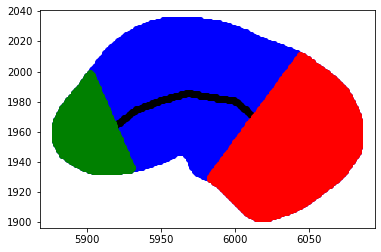

dipole gene= 0.9517829040590048
elongation= 137
aspect ratio= 0.6376811594202898
centroid= [5985 1971]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


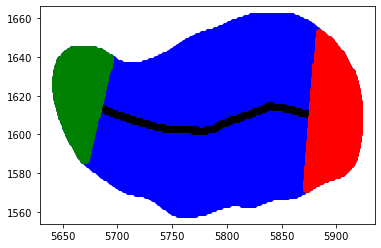

dipole gene= 0.9506299186372631
elongation= 222
aspect ratio= 0.36917562724014336
centroid= [5790 1609]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8776842635256977
elongation= 300
aspect ratio= 0.4098360655737705
centroid= [5821 1886]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


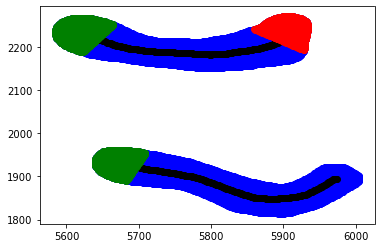

dipole gene= 0.8430545459528039
elongation= 298
aspect ratio= 0.34472934472934474
centroid= [5769 2206]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


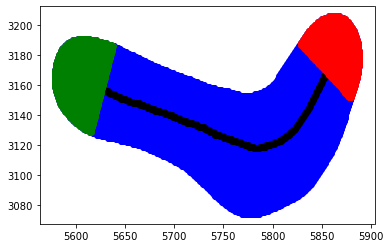

dipole gene= 0.8582345732478153
elongation= 263
aspect ratio= 0.4290322580645161
centroid= [5747 3140]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


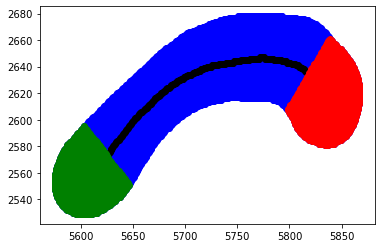

dipole gene= 0.8816726525858973
elongation= 235
aspect ratio= 0.5119453924914675
centroid= [5724 2616]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


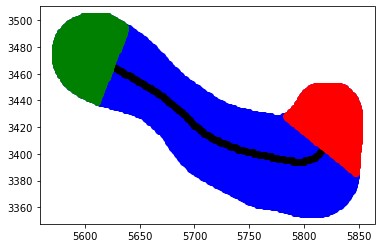

dipole gene= 0.8905903116856627
elongation= 227
aspect ratio= 0.5359712230215827
centroid= [5723 3424]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


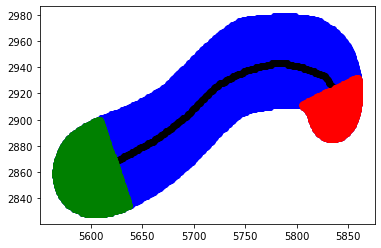

dipole gene= 0.8584430422618268
elongation= 249
aspect ratio= 0.5117845117845118
centroid= [5716 2908]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


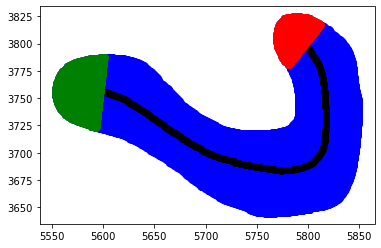

dipole gene= 0.8714121405367328
elongation= 343
aspect ratio= 0.610738255033557
centroid= [5729 3725]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


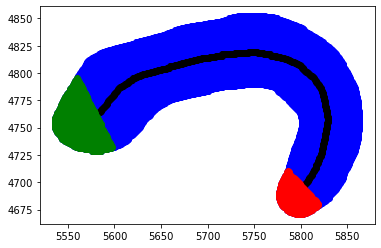

dipole gene= 0.8745308964228191
elongation= 364
aspect ratio= 0.5548780487804879
centroid= [5718 4781]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


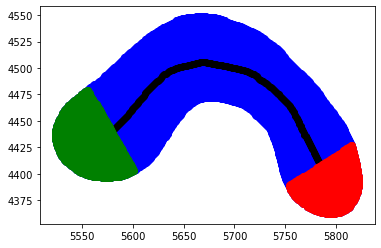

dipole gene= 0.7429846078487886
elongation= 272
aspect ratio= 0.6245847176079734
centroid= [5675 4461]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


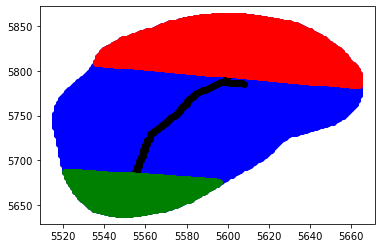

dipole gene= 0.9565741124520222
elongation= 145
aspect ratio= 1.4899328859060403
centroid= [5584 5758]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


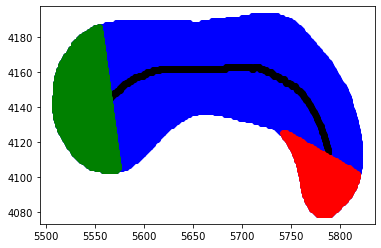

dipole gene= 0.8333647065440868
elongation= 262
aspect ratio= 0.36538461538461536
centroid= [5665 4147]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


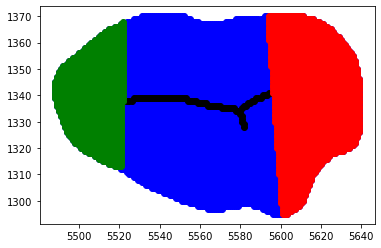

dipole gene= 0.9530910688807273
elongation= 117
aspect ratio= 0.5
centroid= [5567 1335]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


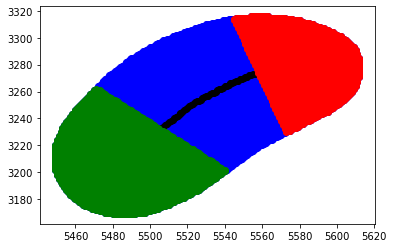

dipole gene= 0.3806385139395935
elongation= 95
aspect ratio= 0.9024390243902439
centroid= [5526 3246]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


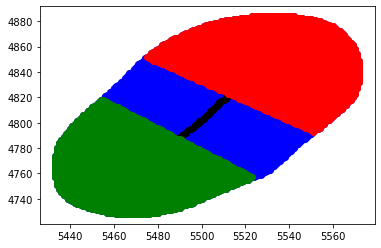

dipole gene= 0.4569185445414266
elongation= 79
aspect ratio= 1.1214285714285714
centroid= [5502 4806]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


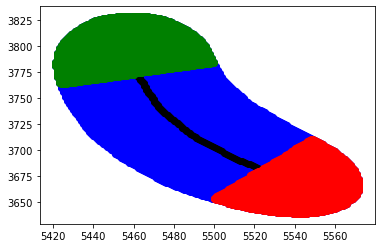

dipole gene= 0.5306197532148711
elongation= 131
aspect ratio= 1.256578947368421
centroid= [5489 3728]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


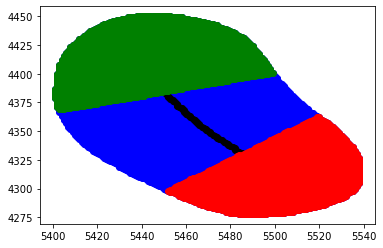

dipole gene= 0.40545028376473236
elongation= 90
aspect ratio= 1.2536231884057971
centroid= [5466 4361]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


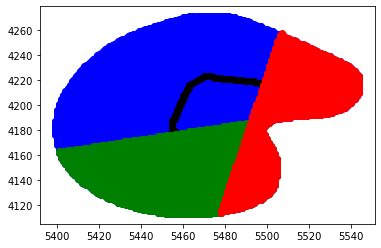

dipole gene= 0.5467796486439738
elongation= 113
aspect ratio= 1.0890410958904109
centroid= [5464 4193]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


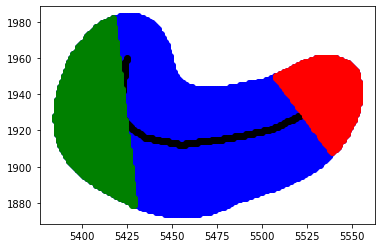

dipole gene= 0.9380242253325888
elongation= 145
aspect ratio= 0.6470588235294118
centroid= [5462 1923]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7217055164747593
elongation= 100
aspect ratio= 1.0476190476190477
centroid= [5450 2501]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


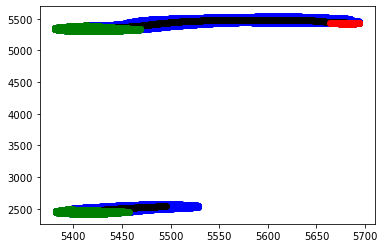

dipole gene= 0.8905020365913312
elongation= 303
aspect ratio= 0.7547770700636943
centroid= [5534 5438]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


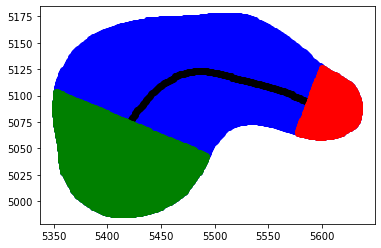

dipole gene= 0.526715110268958
elongation= 218
aspect ratio= 0.6596491228070176
centroid= [5469 5092]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


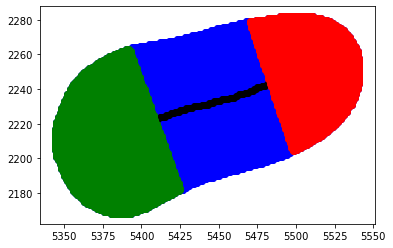

dipole gene= 0.6052533783679007
elongation= 119
aspect ratio= 0.5808080808080808
centroid= [5439 2228]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


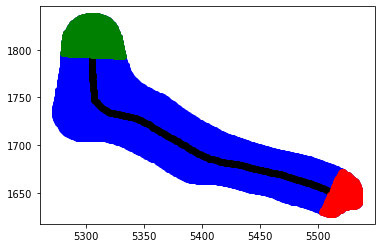

dipole gene= 0.9244649153538746
elongation= 284
aspect ratio= 0.7878787878787878
centroid= [5378 1717]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


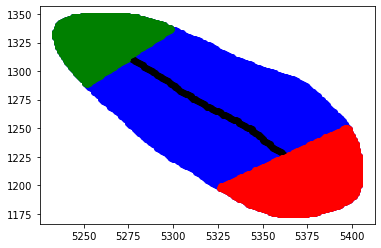

dipole gene= 0.9531495543180533
elongation= 124
aspect ratio= 1.0175438596491229
centroid= [5324 1262]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


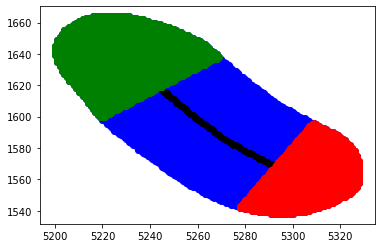

dipole gene= 0.96143633088107
elongation= 86
aspect ratio= 0.9844961240310077
centroid= [5262 1599]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


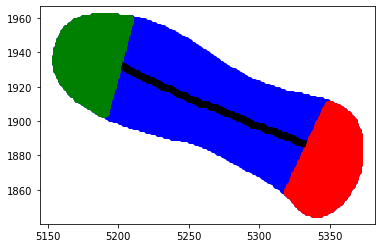

dipole gene= 0.7986325439877776
elongation= 165
aspect ratio= 0.5345622119815668
centroid= [5265 1908]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


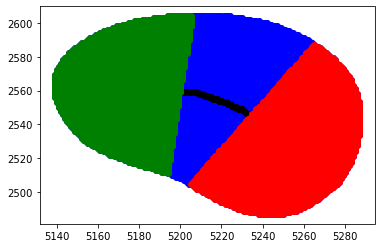

dipole gene= 0.4070733660059775
elongation= 62
aspect ratio= 0.7919463087248322
centroid= [5217 2550]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


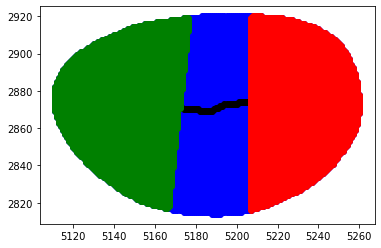

dipole gene= 0.23384068861285742
elongation= 61
aspect ratio= 0.7133333333333334
centroid= [5187 2869]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


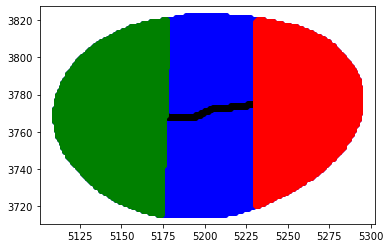

dipole gene= 0.30127935907837183
elongation= 93
aspect ratio= 0.5815217391304348
centroid= [5200 3770]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


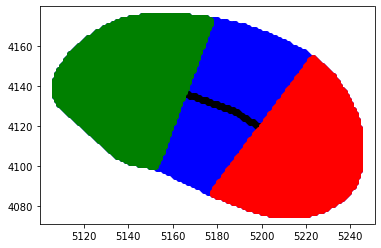

dipole gene= 0.43038617049820854
elongation= 66
aspect ratio= 0.7246376811594203
centroid= [5179 4127]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


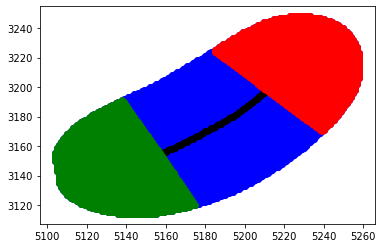

dipole gene= 0.11980462926053516
elongation= 91
aspect ratio= 0.8709677419354839
centroid= [5184 3177]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.16419941805386137
elongation= 38
aspect ratio= 0.8285714285714286
centroid= [5172 3491]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.25350969488843755
elongation= 15
aspect ratio= 1.1304347826086956
centroid= [5139 4436]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


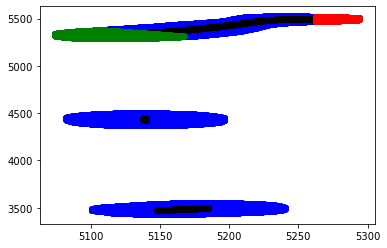

dipole gene= 0.7642986206252927
elongation= 213
aspect ratio= 1.0633484162895928
centroid= [5175 5400]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


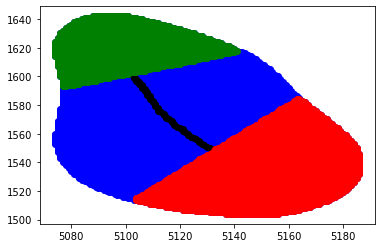

dipole gene= 0.9481284766283794
elongation= 88
aspect ratio= 1.2300884955752212
centroid= [5124 1567]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


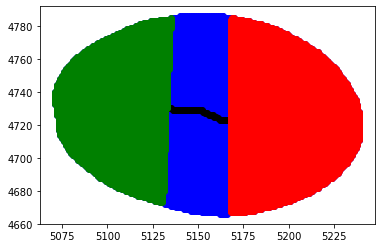

dipole gene= 0.16782788423791606
elongation= 77
aspect ratio= 0.7159763313609467
centroid= [5155 4726]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


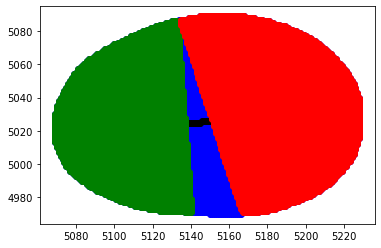

dipole gene= 0.15853189058018552
elongation= 56
aspect ratio= 0.75
centroid= [5149 5028]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


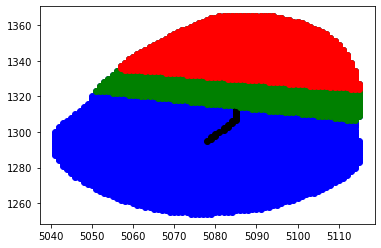

dipole gene= 0.9576728530572252
elongation= 44
aspect ratio= 1.4933333333333334
centroid= [5081 1307]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


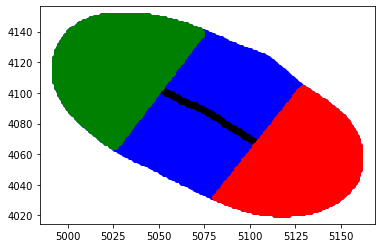

dipole gene= 0.20372373301848531
elongation= 88
aspect ratio= 0.7738095238095238
centroid= [5076 4086]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18754424580275444
elongation= 60
aspect ratio= 0.6370967741935484
centroid= [5039 3148]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4206906070073731
elongation= 39
aspect ratio= 1.0803571428571428
centroid= [5028 2582]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

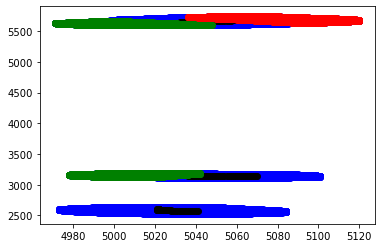

dipole gene= 0.9584529578178497
elongation= 84
aspect ratio= 0.9933333333333333
centroid= [5048 5663]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


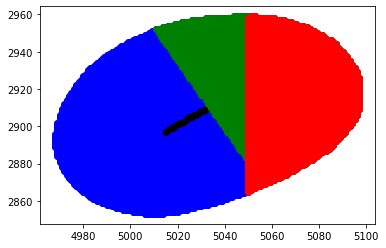

dipole gene= 0.12793489684561882
elongation= 43
aspect ratio= 0.823076923076923
centroid= [5031 2907]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


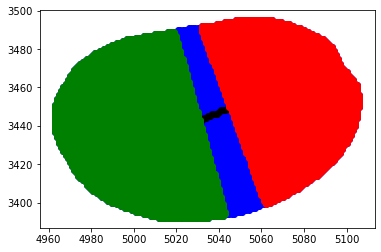

dipole gene= 0.12782450989731195
elongation= 46
aspect ratio= 0.7222222222222222
centroid= [5034 3444]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


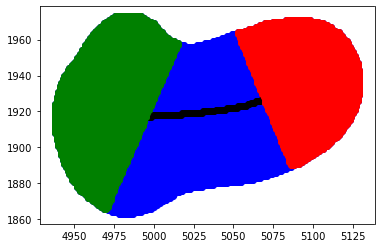

dipole gene= 0.6581742427930993
elongation= 114
aspect ratio= 0.578125
centroid= [5028 1921]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18506095088714297
elongation= 33
aspect ratio= 0.7132352941176471
centroid= [5001 3767]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13440560288407963
elongation= 22
aspect ratio= 1.0287769784172662
centroid= [4997 4735]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


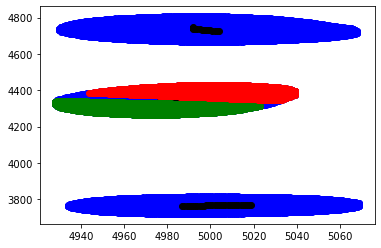

dipole gene= 0.16969295063219317
elongation= 74
aspect ratio= 1.4732142857142858
centroid= [4983 4347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


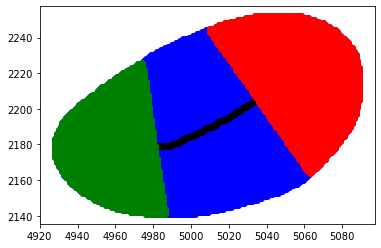

dipole gene= 0.3835841928287759
elongation= 84
aspect ratio= 0.691358024691358
centroid= [5012 2194]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


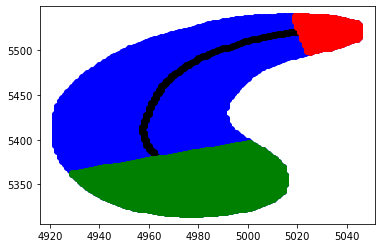

dipole gene= 0.7672470123289534
elongation= 186
aspect ratio= 1.7903225806451613
centroid= [4973 5426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


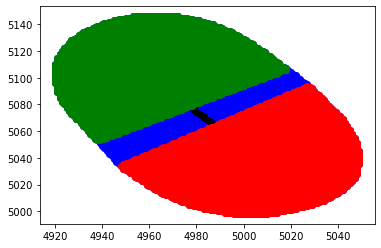

dipole gene= 0.13286259323499972
elongation= 56
aspect ratio= 1.146153846153846
centroid= [4983 5071]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


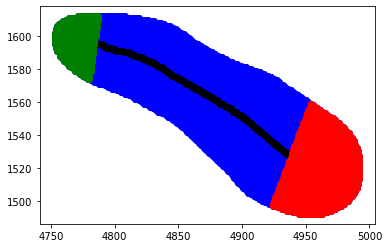

dipole gene= 0.9282843691710183
elongation= 199
aspect ratio= 0.5041666666666667
centroid= [4883 1555]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


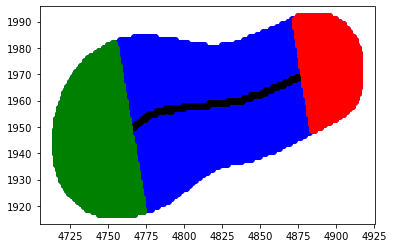

dipole gene= 0.7690044495127976
elongation= 156
aspect ratio= 0.3781094527363184
centroid= [4807 1956]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


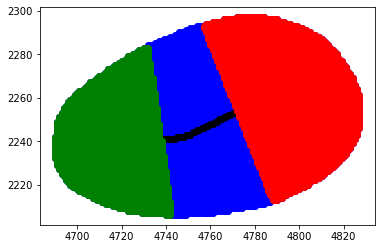

dipole gene= 0.2975917034139749
elongation= 66
aspect ratio= 0.6666666666666666
centroid= [4760 2249]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


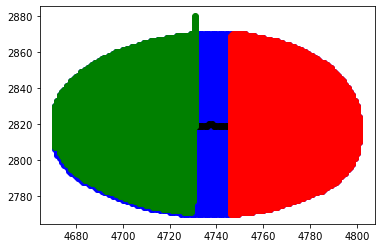

dipole gene= 0.14720394885921562
elongation= 46
aspect ratio= 0.7709923664122137
centroid= [4736 2819]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


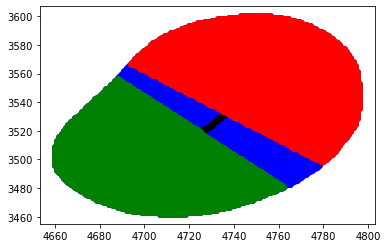

dipole gene= 0.12423197115946237
elongation= 49
aspect ratio= 1.0145985401459854
centroid= [4730 3529]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


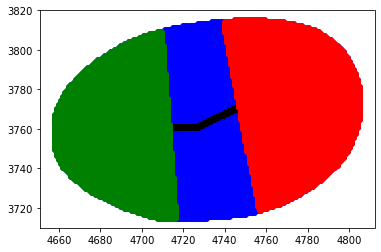

dipole gene= 0.13240391406054483
elongation= 67
aspect ratio= 0.6824324324324325
centroid= [4732 3765]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1734296044948062
elongation= 31
aspect ratio= 0.75177304964539
centroid= [4726 2567]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11978675737856792
elongation= 34
aspect ratio= 0.8417721518987342
centroid= [4733 3149]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


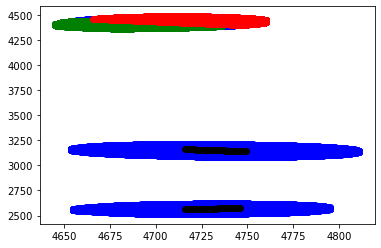

dipole gene= 0.14416407714762042
elongation= 42
aspect ratio= 1.0689655172413792
centroid= [4702 4426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


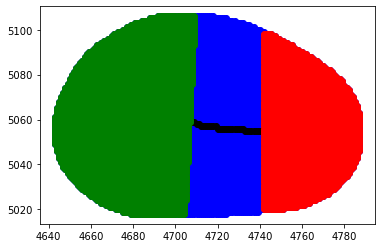

dipole gene= 0.20261301946170324
elongation= 70
aspect ratio= 0.6137931034482759
centroid= [4713 5059]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


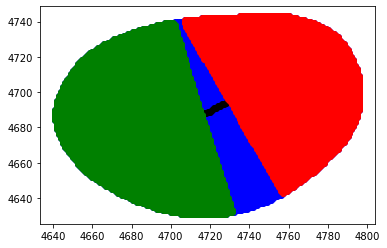

dipole gene= 0.10389350262320503
elongation= 55
aspect ratio= 0.7243589743589743
centroid= [4720 4689]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


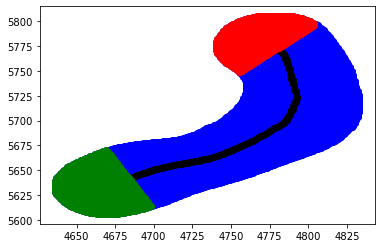

dipole gene= 0.9029106643620584
elongation= 204
aspect ratio= 1.0101010101010102
centroid= [4751 5698]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


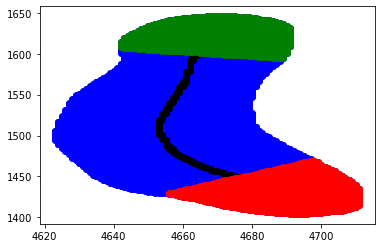

dipole gene= 0.8784855764860929
elongation= 198
aspect ratio= 2.730337078651685
centroid= [4664 1517]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


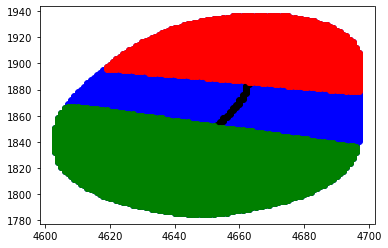

dipole gene= 0.36580009726632295
elongation= 73
aspect ratio= 1.6
centroid= [4653 1859]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


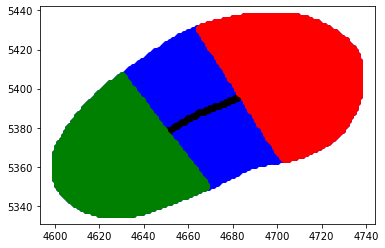

dipole gene= 0.61242609766984
elongation= 71
aspect ratio= 0.7391304347826086
centroid= [4669 5387]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


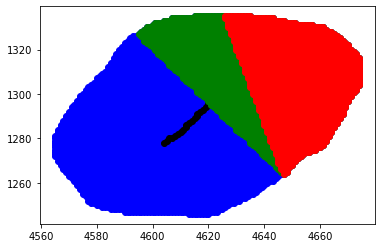

dipole gene= 0.9543464955893989
elongation= 42
aspect ratio= 0.8181818181818182
centroid= [4618 1291]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18299585117980685
elongation= 31
aspect ratio= 0.7964601769911505
centroid= [4616 2516]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


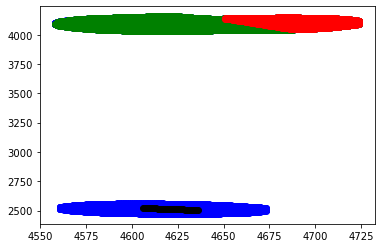

dipole gene= 0.1758525318163913
elongation= 107
aspect ratio= 0.7604790419161677
centroid= [4639 4093]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2112407843733899
elongation= 14
aspect ratio= 0.9186991869918699
centroid= [4605 4345]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


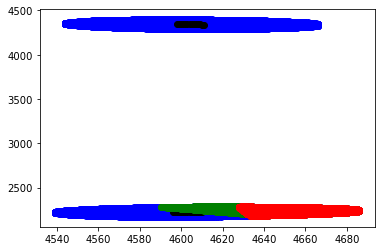

dipole gene= 0.13108980534923714
elongation= 47
aspect ratio= 0.8108108108108109
centroid= [4611 2230]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


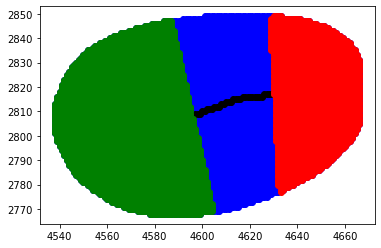

dipole gene= 0.13175269787282565
elongation= 66
aspect ratio= 0.6356589147286822
centroid= [4602 2810]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09753607530710216
elongation= 29
aspect ratio= 0.7410714285714286
centroid= [4589 3479]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13230511547221843
elongation= 39
aspect ratio= 0.7244094488188977
centroid= [4589 3755]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1055777912651328
elongation= 38
aspect ratio= 0.7712418300653595
centroid= [4556 3139]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


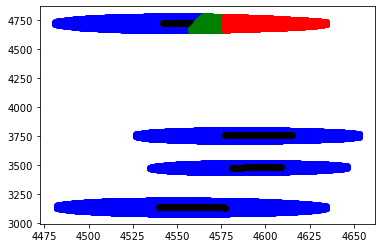

dipole gene= 0.11507173545389149
elongation= 51
aspect ratio= 0.7857142857142857
centroid= [4554 4720]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


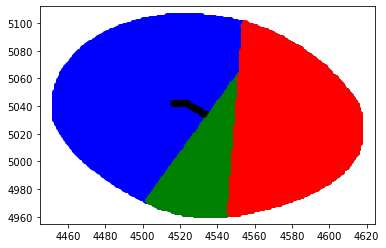

dipole gene= 0.1250752848106818
elongation= 42
aspect ratio= 0.8780487804878049
centroid= [4533 5033]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


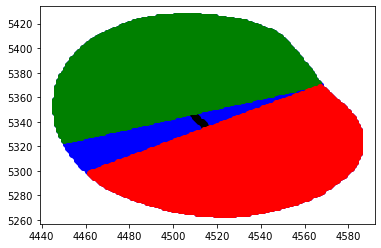

dipole gene= 0.22227184273539802
elongation= 43
aspect ratio= 1.1571428571428573
centroid= [4513 5343]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


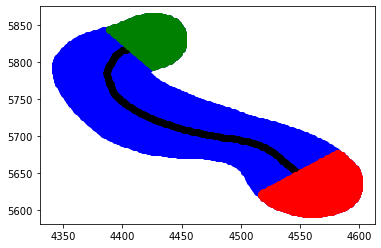

dipole gene= 0.8119144907582783
elongation= 268
aspect ratio= 1.0387596899224807
centroid= [4461 5723]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


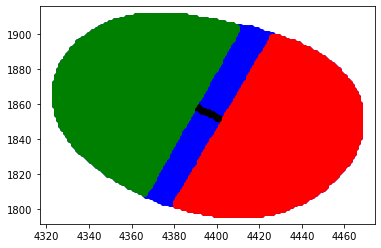

dipole gene= 0.1978637752851035
elongation= 46
aspect ratio= 0.7916666666666666
centroid= [4395 1854]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


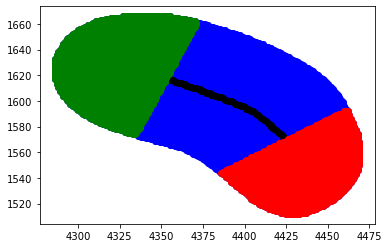

dipole gene= 0.34431140848741115
elongation= 114
aspect ratio= 0.842391304347826
centroid= [4382 1596]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11587686583462374
elongation= 22
aspect ratio= 1.1071428571428572
centroid= [4311 2855]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0
elongation= 40
aspect ratio= 0.8222222222222222
centroid= [4316 3102]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


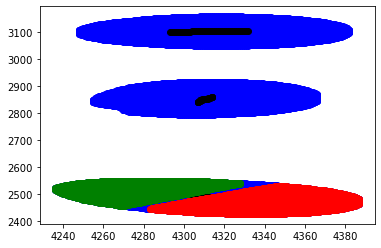

dipole gene= 0.12149079692513111
elongation= 54
aspect ratio= 0.8157894736842105
centroid= [4313 2490]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


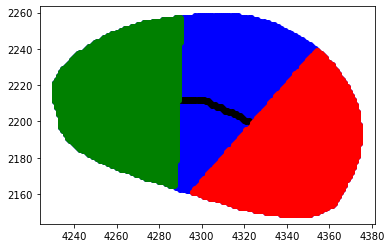

dipole gene= 0.20426643361823607
elongation= 77
aspect ratio= 0.7638888888888888
centroid= [4306 2205]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.17200242795845427
elongation= 36
aspect ratio= 1.0619469026548674
centroid= [4280 4421]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.1325247771062493
elongation= 10
aspect ratio= 1.065040650406504
centroid= [4271 3511]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


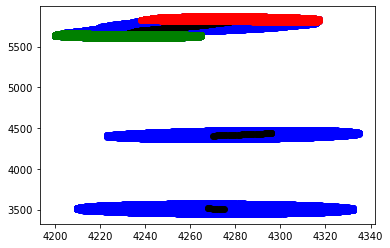

dipole gene= 0.9167661141797669
elongation= 198
aspect ratio= 2.2966101694915255
centroid= [4258 5745]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


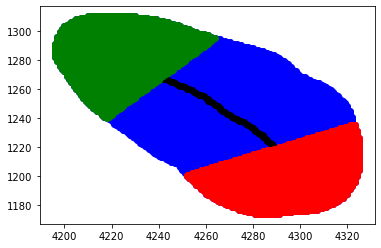

dipole gene= 0.9567262150348573
elongation= 83
aspect ratio= 1.0538461538461539
centroid= [4264 1244]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


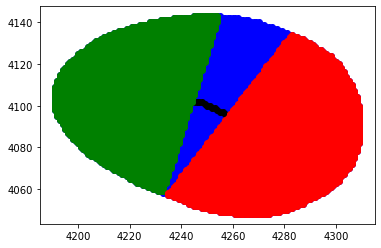

dipole gene= 0.12216062979626262
elongation= 41
aspect ratio= 0.8067226890756303
centroid= [4252 4096]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11162028661513537
elongation= 34
aspect ratio= 0.8538461538461538
centroid= [4255 3767]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


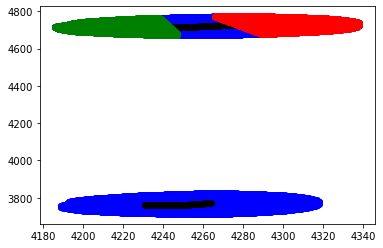

dipole gene= 0.10250394610146793
elongation= 73
aspect ratio= 0.6601307189542484
centroid= [4264 4722]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


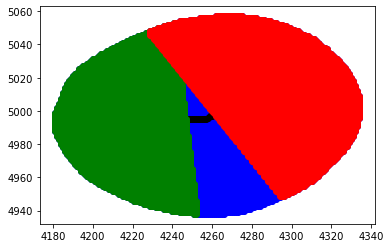

dipole gene= 0.1301194016272447
elongation= 55
aspect ratio= 0.7792207792207793
centroid= [4258 4997]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


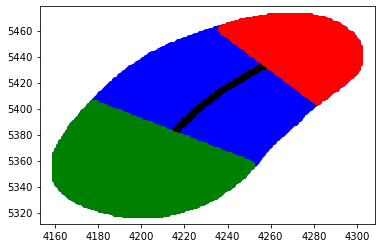

dipole gene= 0.42608924041640706
elongation= 83
aspect ratio= 1.0774647887323943
centroid= [4227 5396]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15461690880413897
elongation= 21
aspect ratio= 0.916030534351145
centroid= [4201 1898]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


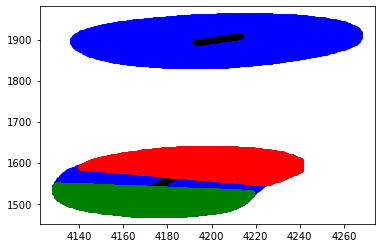

dipole gene= 0.37458163352966506
elongation= 77
aspect ratio= 1.4285714285714286
centroid= [4182 1556]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10818162084342099
elongation= 31
aspect ratio= 1.087378640776699
centroid= [4177 3442]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11397036499992717
elongation= 31
aspect ratio= 0.8914728682170543
centroid= [4170 3118]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


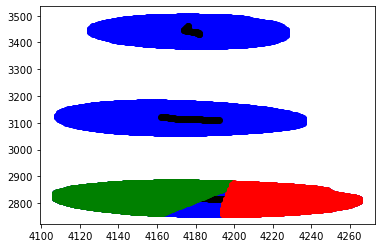

dipole gene= 0.11173116147352655
elongation= 55
aspect ratio= 0.7484276729559748
centroid= [4184 2818]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


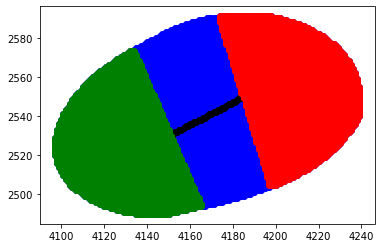

dipole gene= 0.09715453531103221
elongation= 71
aspect ratio= 0.7132867132867133
centroid= [4168 2540]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


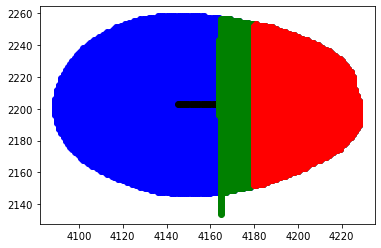

dipole gene= 0.11676972739527913
elongation= 44
aspect ratio= 0.8
centroid= [4157 2202]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09000252310089311
elongation= 14
aspect ratio= 1.1386138613861385
centroid= [4137 3762]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12148281780038934
elongation= 17
aspect ratio= 0.8842975206611571
centroid= [4127 4743]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.08988926415602534
elongation= 17
aspect ratio= 1.062992125984252
centroid= [4115 4068]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10844344452491624
elongation= 9
aspect ratio= 1.0275229357798166
centroid= [4099 4400]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


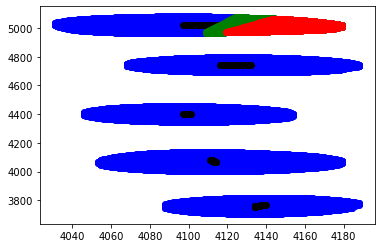

dipole gene= 0.1145600690836055
elongation= 46
aspect ratio= 0.8053691275167785
centroid= [4101 5021]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


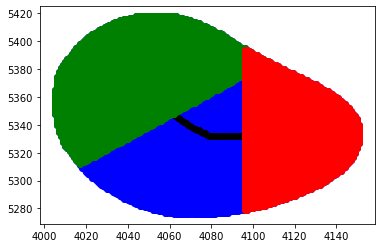

dipole gene= 0.3544953670644016
elongation= 65
aspect ratio= 0.9727891156462585
centroid= [4072 5343]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


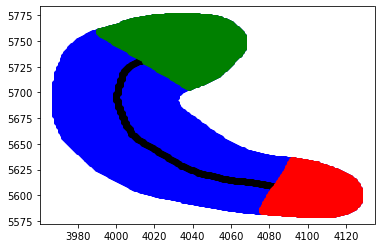

dipole gene= 0.938918430689903
elongation= 194
aspect ratio= 1.20625
centroid= [4031 5672]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

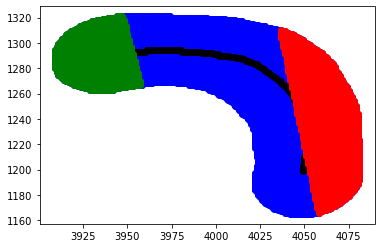

dipole gene= 0.868770047029566
elongation= 175
aspect ratio= 0.9075144508670521
centroid= [4012 1259]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9569181887683806
elongation= 100
aspect ratio= 0.5402298850574713
centroid= [3996  974]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


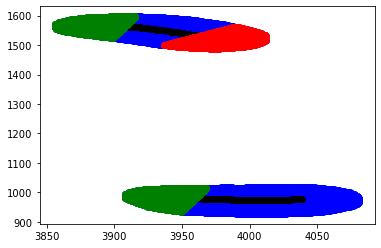

dipole gene= 0.3682834255697782
elongation= 83
aspect ratio= 0.7070063694267515
centroid= [3937 1545]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11718635268709336
elongation= 22
aspect ratio= 0.9831932773109243
centroid= [3876 2207]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


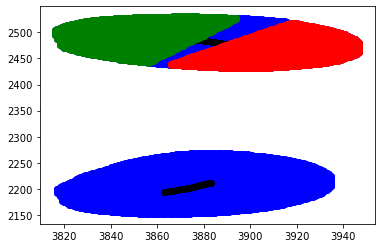

dipole gene= 0.09479675050057461
elongation= 53
aspect ratio= 0.7651515151515151
centroid= [3881 2481]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10036295143530855
elongation= 25
aspect ratio= 0.9609375
centroid= [3869 2798]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


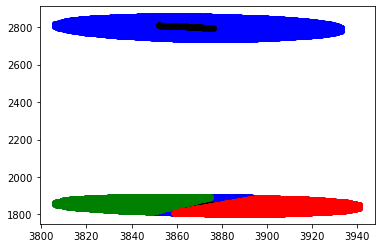

dipole gene= 0.15869597865558596
elongation= 57
aspect ratio= 0.6838235294117647
centroid= [3874 1850]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10257544499999169
elongation= 33
aspect ratio= 0.7816901408450704
centroid= [3862 3123]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10405567272214179
elongation= 21
aspect ratio= 1.0892857142857142
centroid= [3839 4043]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

dipole gene= 0.10902407904838485
elongation= 18
aspect ratio= 1.1130434782608696
centroid= [3828 4401]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10642128442139767
elongation= 22
aspect ratio= 0.9230769230769231
centroid= [3837 3759]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


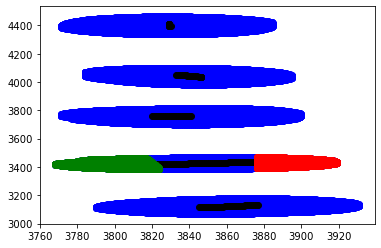

dipole gene= 0.08024750622395088
elongation= 83
aspect ratio= 0.5855263157894737
centroid= [3844 3426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10739521923943861
elongation= 36
aspect ratio= 0.8409090909090909
centroid= [3822 4702]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13688580870991152
elongation= 31
aspect ratio= 1.1282051282051282
centroid= [3802 5019]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

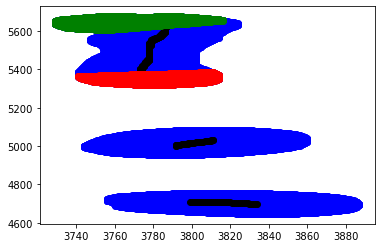

dipole gene= 0.8323415625648072
elongation= 294
aspect ratio= 3.7395833333333335
centroid= [3777 5507]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1732271303390782
elongation= 33
aspect ratio= 1.119047619047619
centroid= [3787 1541]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10925968414731736
elongation= 8
aspect ratio= 0.9907407407407407
centroid= [3760 2181]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10853650062161986
elongation= 16
aspect ratio= 1.0300751879699248
centroid= [3746 2478]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10299357341269123
elongation= 20
aspect ratio= 0.8671875
centroid= [3739 2834]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.14610260365921104
elongation= 35
aspect ratio= 0.9606299212598425
centroid= [3738 1856]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10843077771223096
elongation= 18
aspect ratio= 0.8695652173913043
centroid= [3716 4372]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11662977210855795
elongation= 12
aspect ratio= 1.0925925925925926
centroid= [3717 3743]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10062559343901192
elongation= 15
aspect ratio= 1.0423728813559323
centroid= [3717 3465]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10374334841679589
elongation= 5
aspect ratio= 1.023076923076923
centroid= [3714 4058]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9538336008095152
elongation= 23
aspect ratio= 1.1333333333333333
centroid= [3683  954]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


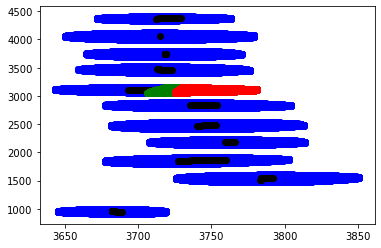

dipole gene= 0.09486453252677025
elongation= 49
aspect ratio= 0.7266187050359713
centroid= [3711 3108]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10698167148965582
elongation= 19
aspect ratio= 0.923728813559322
centroid= [3696 4697]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


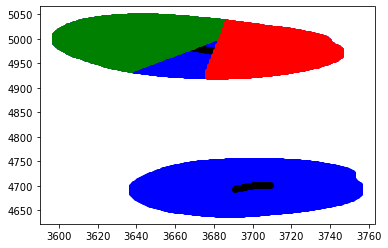

dipole gene= 0.1361654906014504
elongation= 55
aspect ratio= 0.8243243243243243
centroid= [3669 4985]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


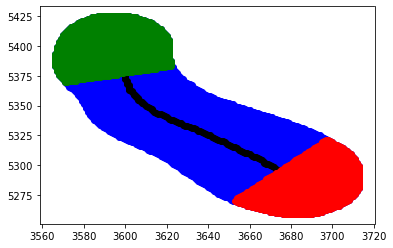

dipole gene= 0.7511278128505835
elongation= 122
aspect ratio= 1.1283783783783783
centroid= [3635 5335]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


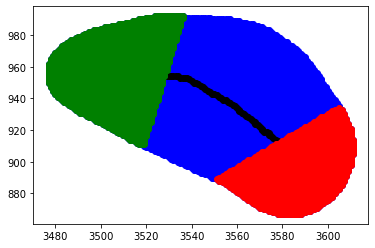

dipole gene= 0.947470097204239
elongation= 91
aspect ratio= 0.9333333333333333
centroid= [3549  936]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09773382525770245
elongation= 20
aspect ratio= 1.0756302521008403
centroid= [3500 2194]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


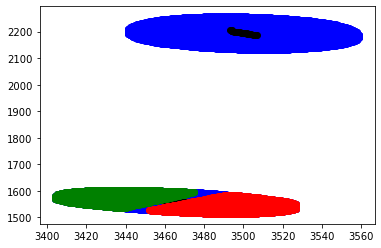

dipole gene= 0.33036585443453054
elongation= 57
aspect ratio= 0.7419354838709677
centroid= [3466 1559]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


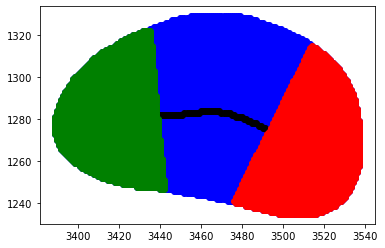

dipole gene= 0.44746265732140655
elongation= 81
aspect ratio= 0.6375838926174496
centroid= [3467 1281]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


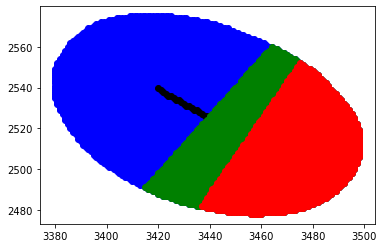

dipole gene= 0.10010449197952777
elongation= 46
aspect ratio= 0.8235294117647058
centroid= [3438 2526]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10239049666997709
elongation= 7
aspect ratio= 1.0272727272727273
centroid= [3430 2806]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11113739387826732
elongation= 14
aspect ratio= 0.9767441860465116
centroid= [3424 3130]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


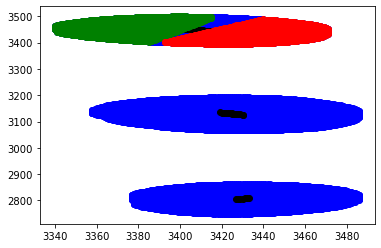

dipole gene= 0.11471347266352828
elongation= 44
aspect ratio= 0.803030303030303
centroid= [3407 3447]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


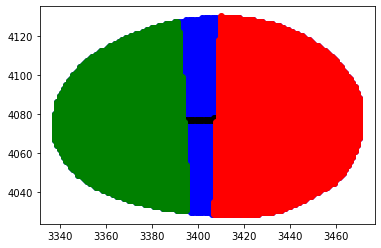

dipole gene= 0.10250883531917844
elongation= 54
aspect ratio= 0.7593984962406015
centroid= [3405 4078]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


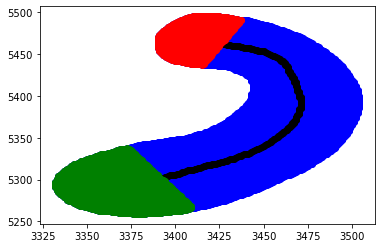

dipole gene= 0.7310616341801136
elongation= 223
aspect ratio= 1.369942196531792
centroid= [3429 5365]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10418617507159635
elongation= 11
aspect ratio= 0.8861788617886179
centroid= [3394 4349]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


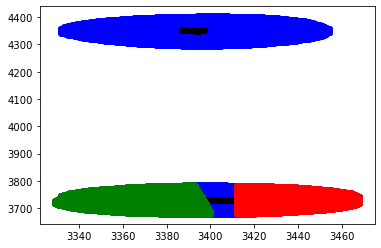

dipole gene= 0.11206624672514322
elongation= 49
aspect ratio= 0.7571428571428571
centroid= [3399 3730]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1323058945665302
elongation= 37
aspect ratio= 1.096774193548387
centroid= [3384 1880]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1035324492179886
elongation= 36
aspect ratio= 0.8602941176470589
centroid= [3388 4718]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15553921776538074
elongation= 34
aspect ratio= 0.875
centroid= [3364 5022]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3091693256370321
elongation= 27
aspect ratio= 0.8269230769230769
centroid= [3348 1589]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


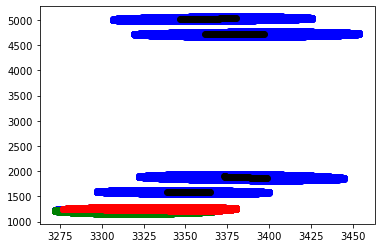

dipole gene= 0.28174115515560916
elongation= 55
aspect ratio= 1.3394495412844036
centroid= [3324 1228]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


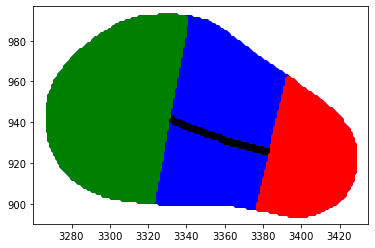

dipole gene= 0.885259011707138
elongation= 94
aspect ratio= 0.6125
centroid= [3344  939]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11161296003058892
elongation= 35
aspect ratio= 0.8582677165354331
centroid= [3310 2814]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1025279731046326
elongation= 24
aspect ratio= 0.8394160583941606
centroid= [3312 2157]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


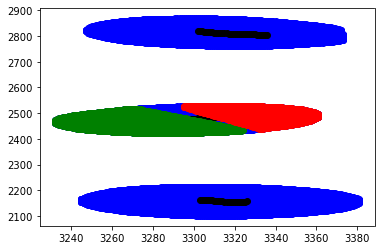

dipole gene= 0.09119122095870792
elongation= 44
aspect ratio= 0.823076923076923
centroid= [3297 2475]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09990041936874472
elongation= 19
aspect ratio= 0.8317757009345794
centroid= [3283 3442]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10992267654502916
elongation= 19
aspect ratio= 0.8615384615384616
centroid= [3292 3112]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09322140194894599
elongation= 15
aspect ratio= 0.8818181818181818
centroid= [3272 3739]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09364596444170183
elongation= 25
aspect ratio= 0.8145161290322581
centroid= [3270 4082]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10337900228647778
elongation= 9
aspect ratio= 1.0
centroid= [3262 4347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.24302677922931917
elongation= 39
aspect ratio= 0.9203539823008849
centroid= [3246 5023]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10889803456943575
elongation= 22
aspect ratio= 0.855072463768116
centroid= [3246 4705]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


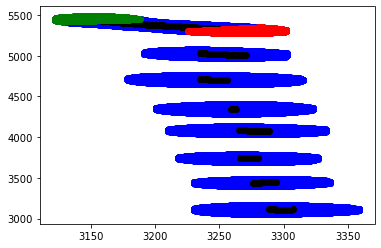

dipole gene= 0.6895736103956601
elongation= 150
aspect ratio= 1.149171270718232
centroid= [3208 5375]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


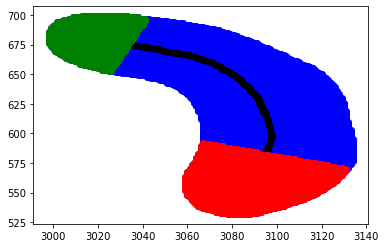

dipole gene= 0.9310661400423382
elongation= 159
aspect ratio= 1.2262773722627738
centroid= [3078  621]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


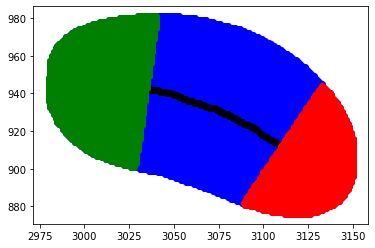

dipole gene= 0.45982496362413416
elongation= 101
aspect ratio= 0.6198830409356725
centroid= [3066  930]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09269455444038653
elongation= 20
aspect ratio= 0.8943089430894309
centroid= [3036 2156]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.11087031764747471
elongation= 7
aspect ratio= 0.9596774193548387
centroid= [3027 1885]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


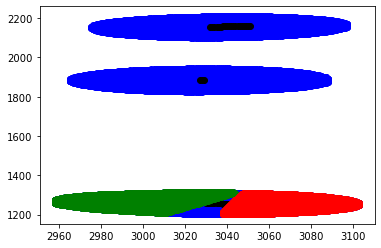

dipole gene= 0.1345355549210422
elongation= 41
aspect ratio= 0.7602739726027398
centroid= [3031 1259]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09930448855665752
elongation= 24
aspect ratio= 0.8558558558558559
centroid= [3008 2482]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


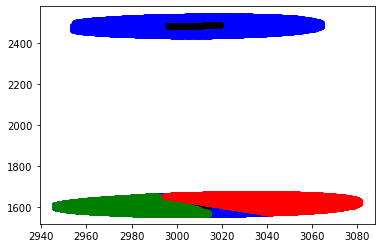

dipole gene= 0.13271689742439777
elongation= 50
aspect ratio= 0.7279411764705882
centroid= [3015 1612]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10038921414835451
elongation= 6
aspect ratio= 1.0
centroid= [2979 2865]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09887358202122638
elongation= 31
aspect ratio= 0.8345864661654135
centroid= [2987 3113]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


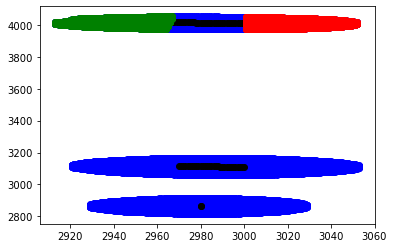

dipole gene= 0.09272447183222744
elongation= 71
aspect ratio= 0.6
centroid= [2983 4013]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09265909144523918
elongation= 37
aspect ratio= 0.7685185185185185
centroid= [2958 3707]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09217987056055468
elongation= 27
aspect ratio= 1.0275229357798166
centroid= [2957 3446]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


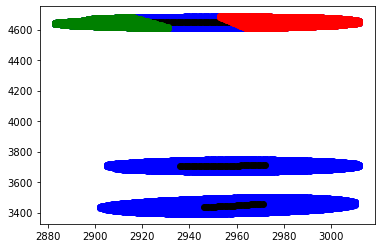

dipole gene= 0.08018411416883608
elongation= 75
aspect ratio= 0.6153846153846154
centroid= [2949 4647]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


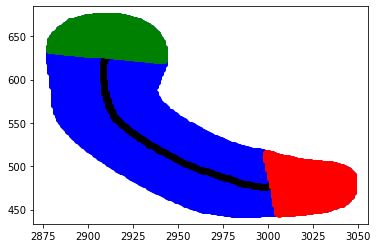

dipole gene= 0.9027964770163083
elongation= 214
aspect ratio= 1.3470588235294119
centroid= [2945  543]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


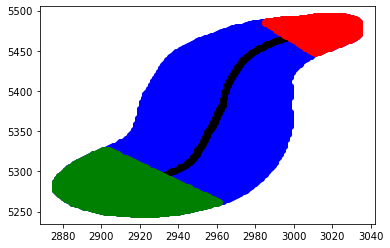

dipole gene= 0.6398698052876155
elongation= 216
aspect ratio= 1.5534591194968554
centroid= [2954 5362]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09628213989966072
elongation= 35
aspect ratio= 0.8110236220472441
centroid= [2931 4395]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10552211500472691
elongation= 32
aspect ratio= 1.2844827586206897
centroid= [2920 4982]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18983735415299144
elongation= 31
aspect ratio= 1.1008403361344539
centroid= [2916  928]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1005118438626384
elongation= 22
aspect ratio= 0.9035087719298246
centroid= [2894 2475]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10998638243991071
elongation= 19
aspect ratio= 0.9302325581395349
centroid= [2889 1255]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11466158342707569
elongation= 17
aspect ratio= 0.875
centroid= [2883 1853]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10512657079265725
elongation= 25
aspect ratio= 0.8656716417910447
centroid= [2881 2166]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10168361820186533
elongation= 22
aspect ratio= 0.95
centroid= [2871 1579]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0805860374372017
elongation= 39
aspect ratio= 0.9439252336448598
centroid= [2849 3714]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

dipole gene= 0.10314673855604975
elongation= 24
aspect ratio= 1.1904761904761905
centroid= [2846 2821]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.09410247743657423
elongation= 8
aspect ratio= 0.9210526315789473
centroid= [2833 4671]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


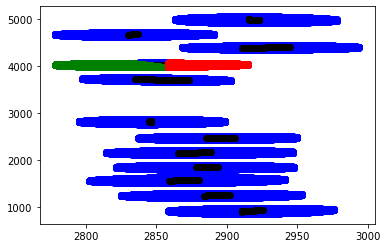

dipole gene= 0.09949340522059166
elongation= 45
aspect ratio= 0.7246376811594203
centroid= [2845 4027]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10775127059915271
elongation= 34
aspect ratio= 0.8571428571428571
centroid= [2832 3423]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1033814531973614
elongation= 28
aspect ratio= 0.8461538461538461
centroid= [2829 3120]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.28502895755136815
elongation= 30
aspect ratio= 1.0258620689655173
centroid= [2804 4968]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


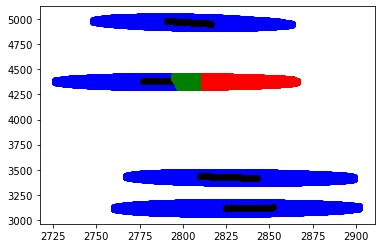

dipole gene= 0.09802403815287504
elongation= 44
aspect ratio= 0.8085106382978723
centroid= [2795 4379]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


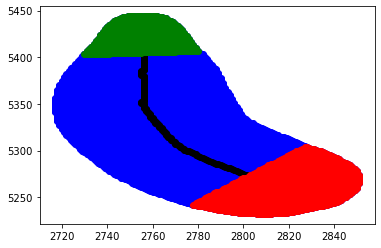

dipole gene= 0.4953887906630631
elongation= 168
aspect ratio= 1.5777777777777777
centroid= [2774 5324]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.16484520386461643
elongation= 14
aspect ratio= 1.0
centroid= [2612 1555]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


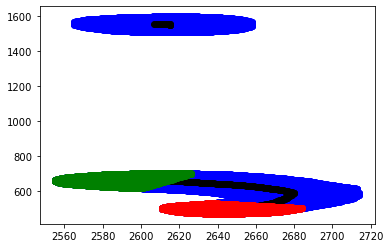

dipole gene= 0.7121492956896016
elongation= 199
aspect ratio= 1.4625
centroid= [2645  600]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


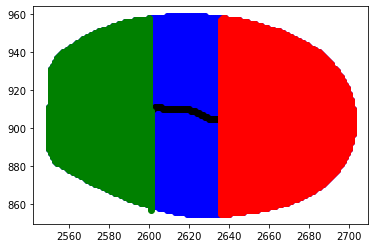

dipole gene= 0.11604766385678077
elongation= 70
aspect ratio= 0.6862745098039216
centroid= [2625  907]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


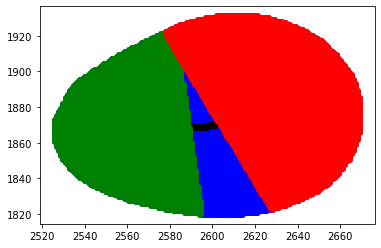

dipole gene= 0.10262297135095973
elongation= 45
aspect ratio= 0.7777777777777778
centroid= [2600 1873]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.0982818041082452
elongation= 7
aspect ratio= 0.9203539823008849
centroid= [2579 2166]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10601710697177913
elongation= 16
aspect ratio= 0.9206349206349206
centroid= [2586 1188]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10710217409800273
elongation= 27
aspect ratio= 0.9516129032258065
centroid= [2577 2482]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11782738281327355
elongation= 20
aspect ratio= 0.911504424778761
centroid= [2562 4397]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10929326289217049
elongation= 14
aspect ratio= 0.98
centroid= [2554 4040]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10836455023063246
elongation= 27
aspect ratio= 0.8968253968253969
centroid= [2560 3434]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10319124267361669
elongation= 25
aspect ratio= 0.8548387096774194
centroid= [2551 2793]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1091175660802512
elongation= 33
aspect ratio= 0.841726618705036
centroid= [2553 3108]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1116134399397356
elongation= 23
aspect ratio= 0.936
centroid= [2538 3742]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


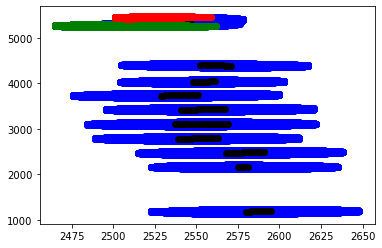

dipole gene= 0.7947434606792597
elongation= 181
aspect ratio= 2.1666666666666665
centroid= [2531 5344]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


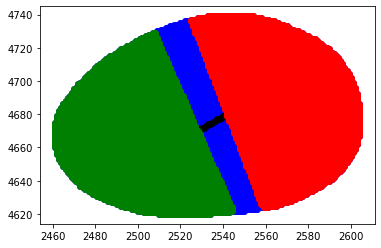

dipole gene= 0.12725401571404651
elongation= 42
aspect ratio= 0.8333333333333334
centroid= [2534 4677]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1316005832648089
elongation= 18
aspect ratio= 0.9338842975206612
centroid= [2515 4969]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


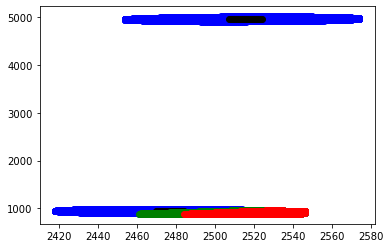

dipole gene= 0.11198555777589271
elongation= 42
aspect ratio= 0.875968992248062
centroid= [2482  933]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10344108424395078
elongation= 7
aspect ratio= 0.9478260869565217
centroid= [2466 1887]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12770984040048985
elongation= 60
aspect ratio= 0.7165354330708661
centroid= [2467 1211]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12969271948550365
elongation= 14
aspect ratio= 0.9217391304347826
centroid= [2462 1571]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


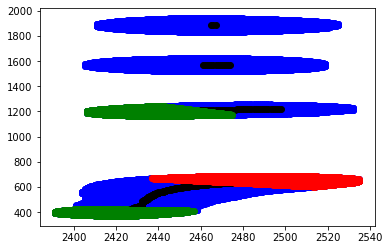

dipole gene= 0.6762088989433891
elongation= 248
aspect ratio= 2.220689655172414
centroid= [2451  552]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0
elongation= 40
aspect ratio= 0.7894736842105263
centroid= [2453 2181]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10223046015282411
elongation= 6
aspect ratio= 0.85
centroid= [2444 2526]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10528740246748805
elongation= 23
aspect ratio= 0.8076923076923077
centroid= [2423 2818]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11006859284689655
elongation= 11
aspect ratio= 0.968503937007874
centroid= [2403 3407]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


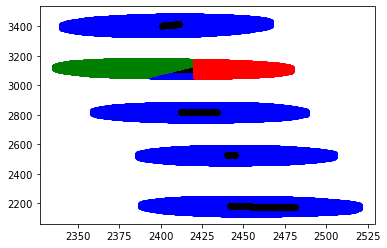

dipole gene= 0.10205644882642663
elongation= 49
aspect ratio= 0.7083333333333334
centroid= [2407 3114]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.1371422482472763
elongation= 9
aspect ratio= 0.9814814814814815
centroid= [2372 4650]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10540530273251897
elongation= 21
aspect ratio= 1.1730769230769231
centroid= [2335 4359]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0
elongation= 40
aspect ratio= 0.8968253968253969
centroid= [2337 4044]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


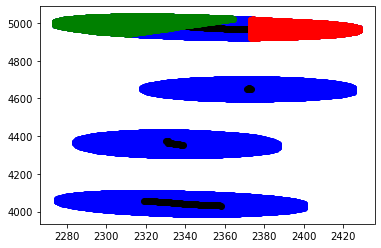

dipole gene= 0.17967139729420636
elongation= 66
aspect ratio= 0.7354838709677419
centroid= [2349 4979]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09223981139917761
elongation= 34
aspect ratio= 0.8524590163934426
centroid= [2335 3712]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


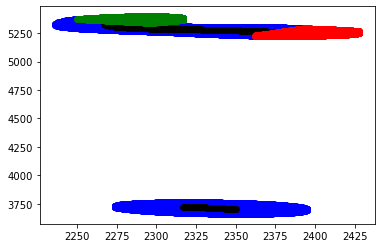

dipole gene= 0.8034580075143494
elongation= 199
aspect ratio= 0.9067357512953368
centroid= [2321 5300]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12328993612517405
elongation= 35
aspect ratio= 0.7647058823529411
centroid= [2204  938]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


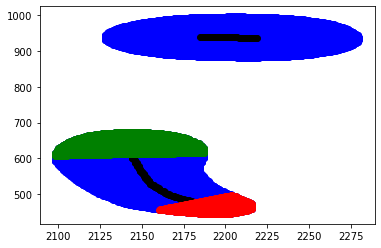

dipole gene= 0.5843793385878666
elongation= 165
aspect ratio= 1.9243697478991597
centroid= [2152  561]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.11261775205012323
elongation= 10
aspect ratio= 0.8407079646017699
centroid= [2148 1259]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.09006460231844843
elongation= 9
aspect ratio= 0.9391304347826087
centroid= [2132 3062]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11491292331221652
elongation= 37
aspect ratio= 0.8559322033898306
centroid= [2130 1530]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10586724370319145
elongation= 25
aspect ratio= 1.0940170940170941
centroid= [2126 2443]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10819360003013967
elongation= 9
aspect ratio= 0.9512195121951219
centroid= [2128 2770]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10483072829517742
elongation= 25
aspect ratio= 0.9576271186440678
centroid= [2124 1832]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11300218504131923
elongation= 13
aspect ratio= 0.905982905982906
centroid= [2115 4038]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10782433034530489
elongation= 13
aspect ratio= 0.9401709401709402
centroid= [2106 3706]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


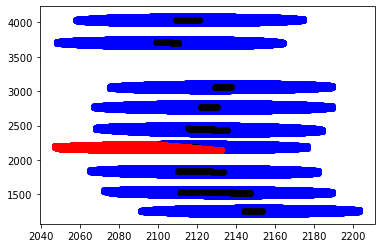

dipole gene= 0.09976889356387111
elongation= 42
aspect ratio= 0.8
centroid= [2112 2187]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10689097276847154
elongation= 23
aspect ratio= 0.9230769230769231
centroid= [2085 3408]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


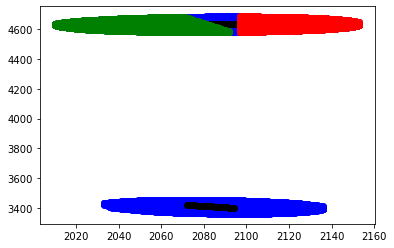

dipole gene= 0.11886130161088544
elongation= 42
aspect ratio= 0.75
centroid= [2083 4631]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11437772846892558
elongation= 12
aspect ratio= 0.9365079365079365
centroid= [2063 4358]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


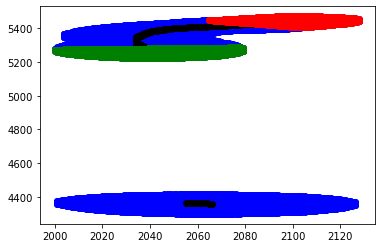

dipole gene= 0.8396039374716259
elongation= 194
aspect ratio= 1.937984496124031
centroid= [2051 5347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1248559125183712
elongation= 28
aspect ratio= 1.015625
centroid= [2035 1201]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


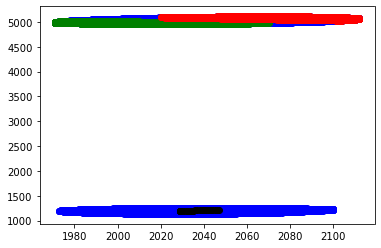

dipole gene= 0.12857214346077536
elongation= 81
aspect ratio= 1.1690140845070423
centroid= [2042 5032]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


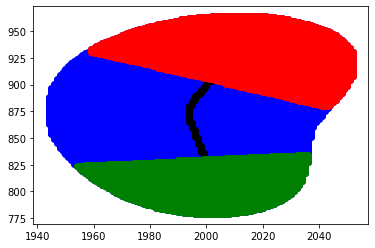

dipole gene= 0.12525455313620976
elongation= 105
aspect ratio= 1.7064220183486238
centroid= [1997  875]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


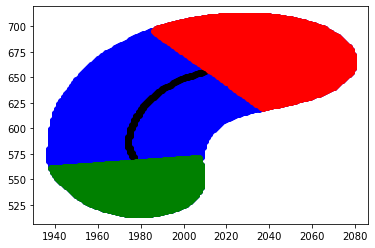

dipole gene= 0.6404221292033492
elongation= 138
aspect ratio= 1.3636363636363635
centroid= [1998  624]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10798826846770708
elongation= 17
aspect ratio= 0.968
centroid= [1997 1822]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11920820393232365
elongation= 34
aspect ratio= 0.8676470588235294
centroid= [2004 1530]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.08911945193413173
elongation= 21
aspect ratio= 0.8272727272727273
centroid= [1989 2177]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10168871049998356
elongation= 33
aspect ratio= 0.8264462809917356
centroid= [1990 2793]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10832966211056268
elongation= 22
aspect ratio= 0.8646616541353384
centroid= [1988 3083]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10869205961229456
elongation= 16
aspect ratio= 0.9590163934426229
centroid= [1969 3403]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10964869751087658
elongation= 21
aspect ratio= 0.8625954198473282
centroid= [1964 2502]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.09667635837516868
elongation= 7
aspect ratio= 0.9915254237288136
centroid= [1938 3742]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


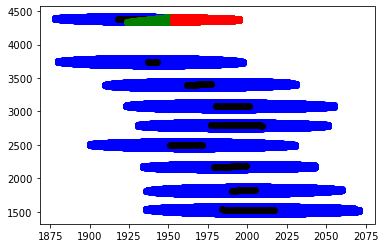

dipole gene= 0.11168811140444025
elongation= 48
aspect ratio= 0.7372881355932204
centroid= [1934 4379]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1689071168988789
elongation= 39
aspect ratio= 0.837037037037037
centroid= [1911 4936]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


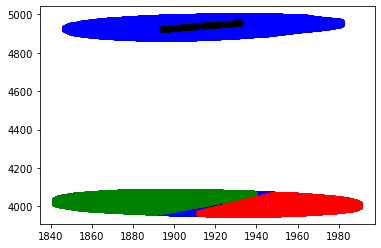

dipole gene= 0.12070142246038464
elongation= 48
aspect ratio= 0.785234899328859
centroid= [1915 4018]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11264715828954219
elongation= 37
aspect ratio= 0.7265625
centroid= [1904 4621]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


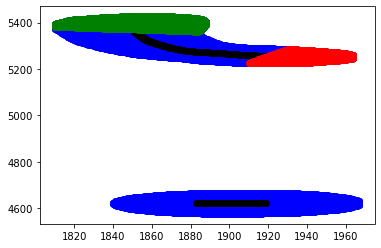

dipole gene= 0.8732749624320795
elongation= 173
aspect ratio= 1.3161290322580645
centroid= [1873 5320]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


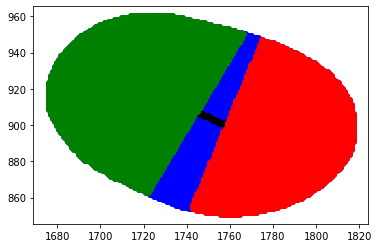

dipole gene= 0.2460034105234479
elongation= 53
aspect ratio= 0.7746478873239436
centroid= [1746  906]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13025173532935333
elongation= 33
aspect ratio= 0.87248322147651
centroid= [1743 1521]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.13072262996993167
elongation= 9
aspect ratio= 0.9754098360655737
centroid= [1721 1180]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1106283912368561
elongation= 27
aspect ratio= 0.8467153284671532
centroid= [1719 1844]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


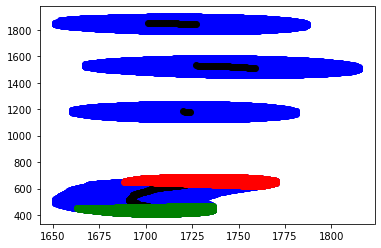

dipole gene= 0.7001808684284705
elongation= 212
aspect ratio= 2.3583333333333334
centroid= [1705  554]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.08416825434858557
elongation= 29
aspect ratio= 0.9375
centroid= [1700 2431]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1106891983986008
elongation= 11
aspect ratio= 1.117117117117117
centroid= [1694 2166]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09224685090089911
elongation= 22
aspect ratio= 0.8828125
centroid= [1699 2800]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1148618250816537
elongation= 14
aspect ratio= 1.1057692307692308
centroid= [1678 3103]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

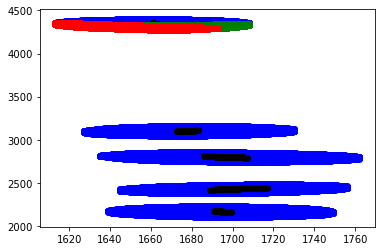

dipole gene= 0.38039830522758433
elongation= 56
aspect ratio= 1.28125
centroid= [1661 4340]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


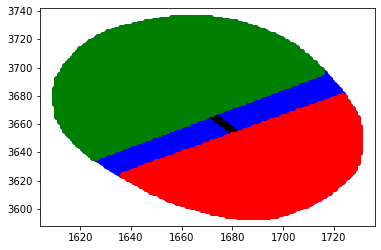

dipole gene= 0.1368102166357914
elongation= 43
aspect ratio= 1.165289256198347
centroid= [1671 3666]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


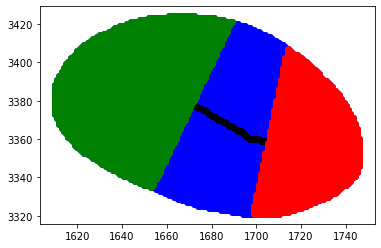

dipole gene= 0.1431872934318834
elongation= 69
aspect ratio= 0.7591240875912408
centroid= [1678 3372]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1285506113722961
elongation= 21
aspect ratio= 0.9090909090909091
centroid= [1643 3984]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


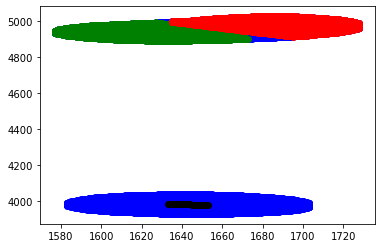

dipole gene= 0.21835444376277624
elongation= 57
aspect ratio= 0.9013157894736842
centroid= [1656 4954]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13783665660762626
elongation= 33
aspect ratio= 0.8823529411764706
centroid= [1633 4681]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


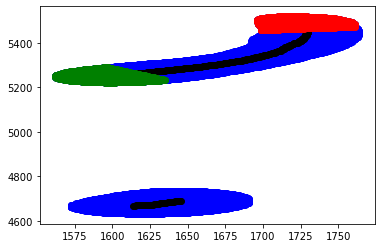

dipole gene= 0.8537990488314731
elongation= 257
aspect ratio= 1.4729064039408868
centroid= [1683 5357]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1681753845703
elongation= 30
aspect ratio= 0.75
centroid= [1592 1534]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1848932297071332
elongation= 30
aspect ratio= 0.7338709677419355
centroid= [1568 1173]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


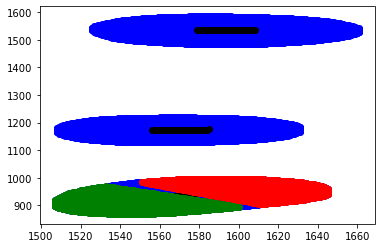

dipole gene= 0.2113796955366153
elongation= 53
aspect ratio= 0.920863309352518
centroid= [1573  934]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


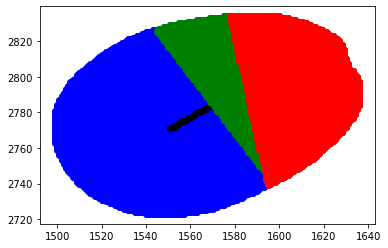

dipole gene= 0.10849302823866122
elongation= 45
aspect ratio= 0.8115942028985508
centroid= [1566 2780]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


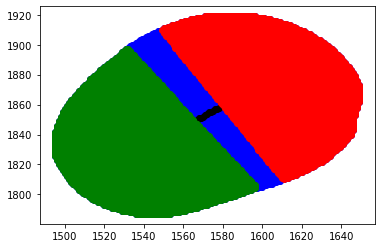

dipole gene= 0.10862390911163063
elongation= 44
aspect ratio= 0.8580645161290322
centroid= [1571 1853]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13142902191880113
elongation= 28
aspect ratio= 0.9349593495934959
centroid= [1542 3368]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


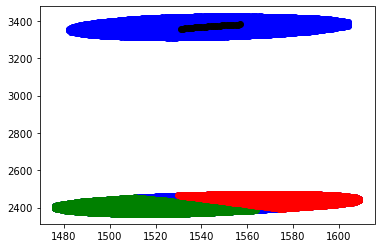

dipole gene= 0.09516803313123487
elongation= 54
aspect ratio= 0.8208955223880597
centroid= [1541 2421]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


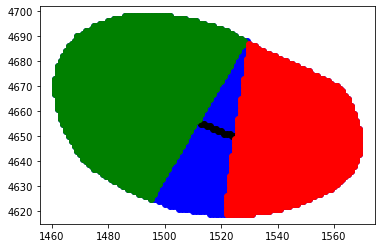

dipole gene= 0.34906014824218284
elongation= 52
aspect ratio= 0.7339449541284404
centroid= [1513 4657]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15193806656861097
elongation= 37
aspect ratio= 0.9112903225806451
centroid= [1519 3080]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10612047441609
elongation= 9
aspect ratio= 1.0155038759689923
centroid= [1517 2148]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.17407761862822074
elongation= 28
aspect ratio= 0.9736842105263158
centroid= [1504 4013]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1883673443808169
elongation= 26
aspect ratio= 0.7983870967741935
centroid= [1508 3710]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.22176647531336593
elongation= 14
aspect ratio= 0.8925619834710744
centroid= [1500 4354]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


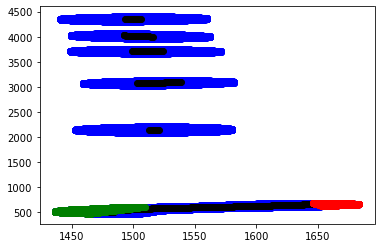

dipole gene= 0.8377487673238282
elongation= 227
aspect ratio= 0.891566265060241
centroid= [1548  586]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-47-87934e758dac>:

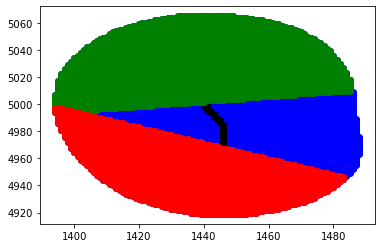

dipole gene= 0.16811784242474487
elongation= 66
aspect ratio= 1.5473684210526315
centroid= [1442 4992]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


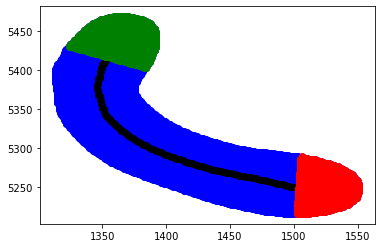

dipole gene= 0.7745121427876984
elongation= 272
aspect ratio= 1.0669456066945606
centroid= [1409 5319]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12333365624427312
elongation= 34
aspect ratio= 0.7984496124031008
centroid= [1312 2137]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10502205014814975
elongation= 33
aspect ratio= 0.9166666666666666
centroid= [1313 1862]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.19829304350530594
elongation= 35
aspect ratio= 0.9918032786885246
centroid= [1286 1521]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


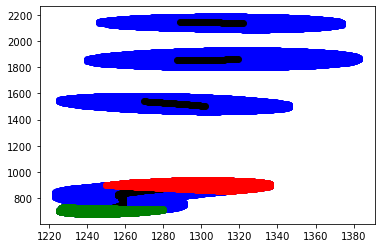

dipole gene= 0.7627296310468715
elongation= 199
aspect ratio= 2.263157894736842
centroid= [1269  821]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


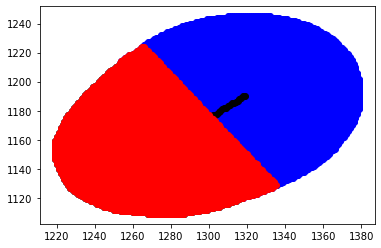

dipole gene= 0.18821425886371201
elongation= 54
aspect ratio= 0.8509316770186336
centroid= [1300 1176]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09068075514535076
elongation= 25
aspect ratio= 1.0350877192982457
centroid= [1247 2424]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


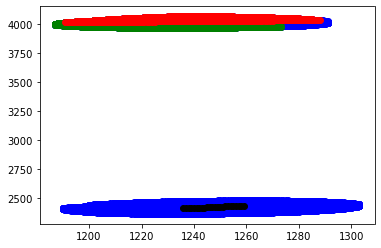

dipole gene= 0.33472161462816097
elongation= 44
aspect ratio= 0.9619047619047619
centroid= [1240 4012]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


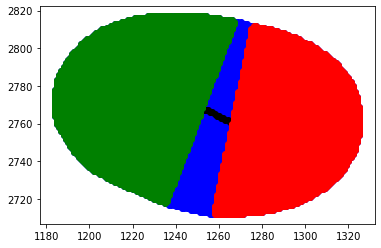

dipole gene= 0.1913048283220813
elongation= 43
aspect ratio= 0.7464788732394366
centroid= [1254 2765]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


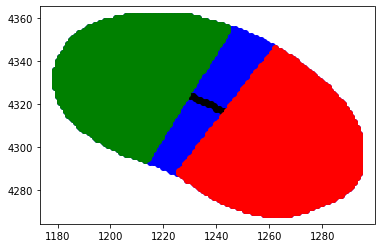

dipole gene= 0.5172723995890973
elongation= 58
aspect ratio= 0.8017241379310345
centroid= [1238 4317]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18197151828098768
elongation= 24
aspect ratio= 1.2065217391304348
centroid= [1214 3349]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


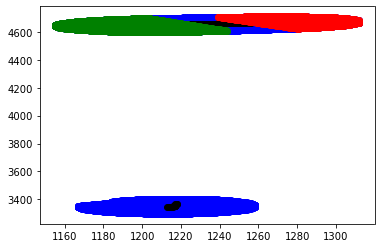

dipole gene= 0.27613321072437336
elongation= 64
aspect ratio= 0.7341772151898734
centroid= [1233 4657]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2510016403160855
elongation= 22
aspect ratio= 0.9423076923076923
centroid= [1205 3644]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11905959178957072
elongation= 22
aspect ratio= 0.8174603174603174
centroid= [1205 3069]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


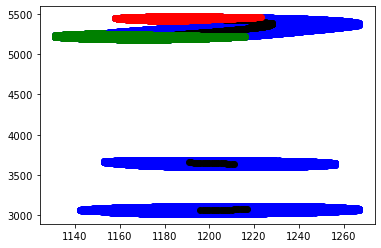

dipole gene= 0.8882253450772707
elongation= 232
aspect ratio= 2.1313868613138687
centroid= [1203 5324]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


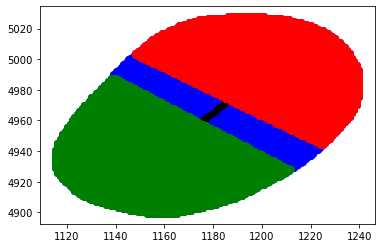

dipole gene= 0.23998806812536366
elongation= 44
aspect ratio= 1.0317460317460319
centroid= [1178 4963]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


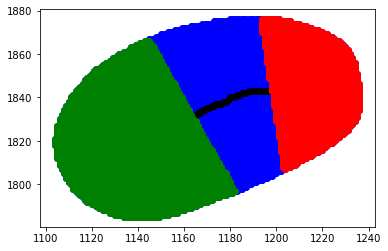

dipole gene= 0.09376556320314798
elongation= 65
aspect ratio= 0.6917293233082706
centroid= [1168 1832]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


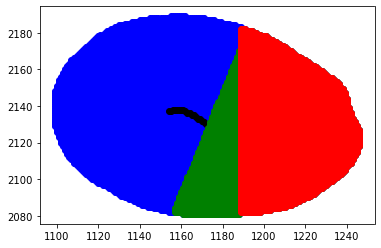

dipole gene= 0.11429548017349826
elongation= 53
aspect ratio= 0.7364864864864865
centroid= [1170 2133]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


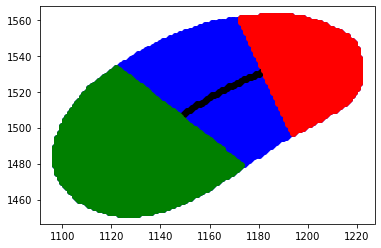

dipole gene= 0.30724167494762883
elongation= 64
aspect ratio= 0.888
centroid= [1156 1510]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10978914596320415
elongation= 23
aspect ratio= 0.9393939393939394
centroid= [1127 2442]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


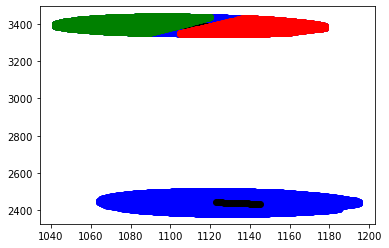

dipole gene= 0.2486213664344074
elongation= 42
aspect ratio= 0.7007299270072993
centroid= [1108 3391]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


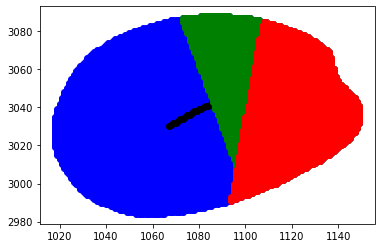

dipole gene= 0.11717672033720058
elongation= 42
aspect ratio= 0.7954545454545454
centroid= [1080 3036]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2410242107179681
elongation= 35
aspect ratio= 0.8195488721804511
centroid= [1078 3711]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


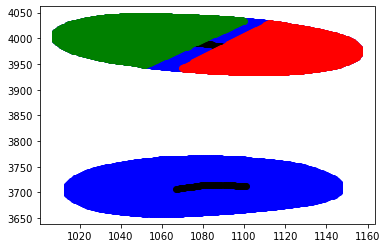

dipole gene= 0.19272233634976818
elongation= 55
aspect ratio= 0.738255033557047
centroid= [1081 3989]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.12327335490576197
elongation= 7
aspect ratio= 0.9328358208955224
centroid= [1073 2788]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


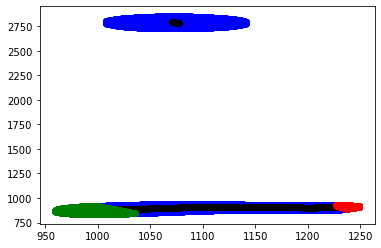

dipole gene= 0.8947801367498814
elongation= 244
aspect ratio= 0.3470790378006873
centroid= [1088  894]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


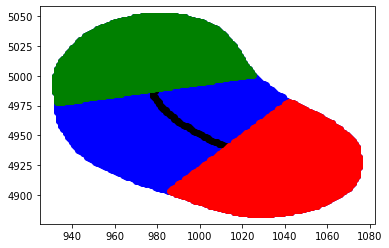

dipole gene= 0.3805075812183011
elongation= 90
aspect ratio= 1.1597222222222223
centroid= [ 998 4962]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


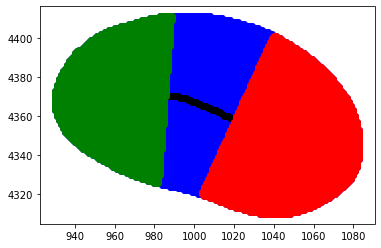

dipole gene= 0.3253166258055507
elongation= 77
aspect ratio= 0.6623376623376623
centroid= [1008 4361]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


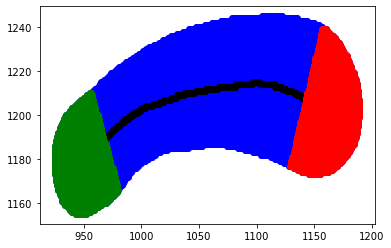

dipole gene= 0.7910225358763728
elongation= 212
aspect ratio= 0.3433962264150943
centroid= [1062 1204]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


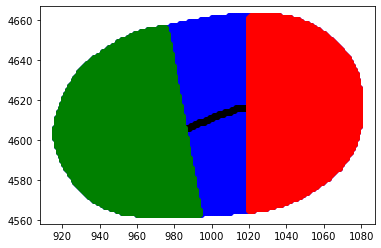

dipole gene= 0.21794787858760625
elongation= 74
aspect ratio= 0.6097560975609756
centroid= [ 999 4611]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


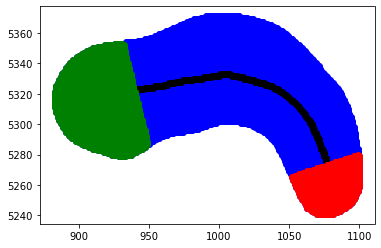

dipole gene= 0.9498525414676078
elongation= 190
aspect ratio= 0.6009174311926605
centroid= [ 998 5316]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


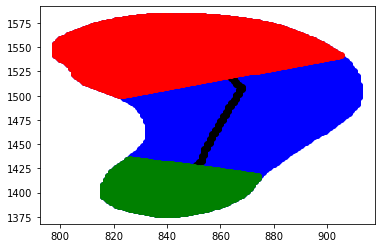

dipole gene= 0.8040590567523704
elongation= 139
aspect ratio= 1.7826086956521738
centroid= [ 855 1493]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3322549822288941
elongation= 27
aspect ratio= 1.2523364485981308
centroid= [ 841 2145]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


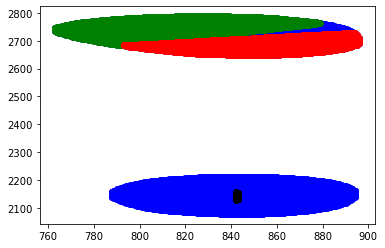

dipole gene= 0.18550172672401283
elongation= 41
aspect ratio= 1.044776119402985
centroid= [ 833 2720]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.20649216729849418
elongation= 23
aspect ratio= 1.18348623853211
centroid= [ 812 2459]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


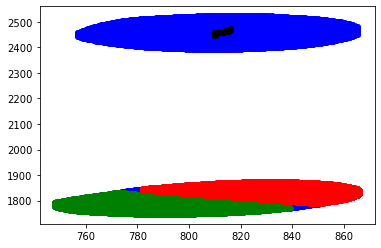

dipole gene= 0.41598022340853463
elongation= 55
aspect ratio= 1.0588235294117647
centroid= [ 809 1808]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


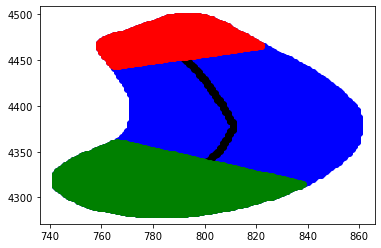

dipole gene= 0.6516833039537125
elongation= 159
aspect ratio= 1.8235294117647058
centroid= [ 802 4380]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


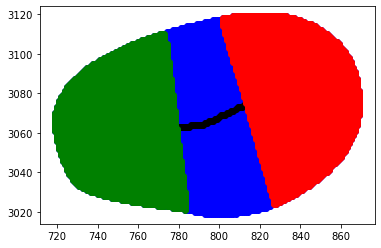

dipole gene= 0.19536540950421505
elongation= 71
aspect ratio= 0.6688741721854304
centroid= [ 796 3068]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


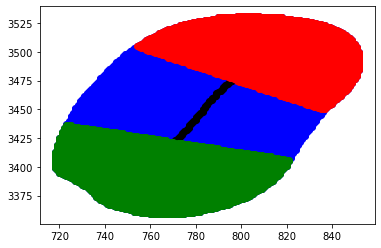

dipole gene= 0.32591018103869385
elongation= 88
aspect ratio= 1.2814814814814814
centroid= [ 783 3447]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


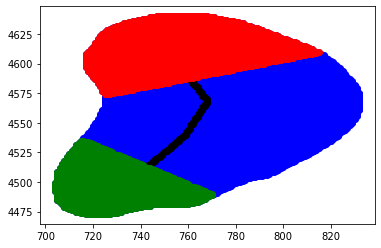

dipole gene= 0.6929190832061503
elongation= 101
aspect ratio= 1.302325581395349
centroid= [ 764 4558]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5989302388582256
elongation= 29
aspect ratio= 1.190909090909091
centroid= [ 748 3726]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


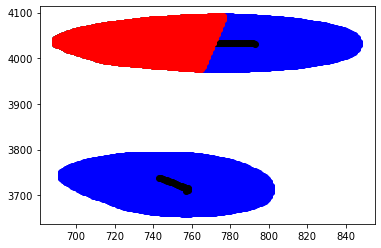

dipole gene= 0.319516906306328
elongation= 58
aspect ratio= 0.7358490566037735
centroid= [ 770 4033]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


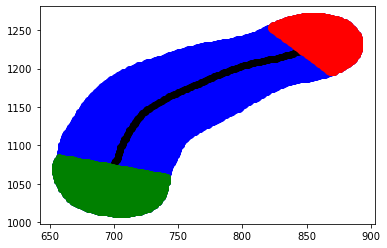

dipole gene= 0.9047264426391043
elongation= 223
aspect ratio= 1.084033613445378
centroid= [ 754 1149]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


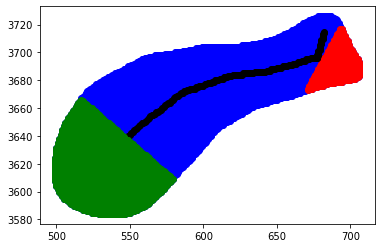

dipole gene= 0.8978805239802021
elongation= 172
aspect ratio= 0.6875
centroid= [ 586 3657]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


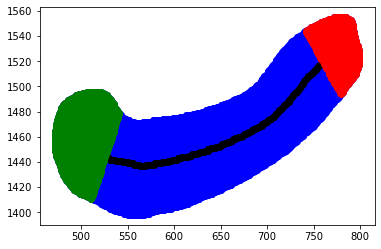

dipole gene= 0.8614775328685423
elongation= 276
aspect ratio= 0.4817073170731707
centroid= [ 631 1465]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


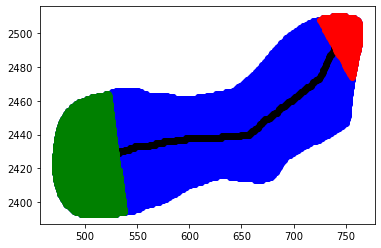

dipole gene= 0.7864464760904585
elongation= 247
aspect ratio= 0.40273037542662116
centroid= [ 617 2444]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


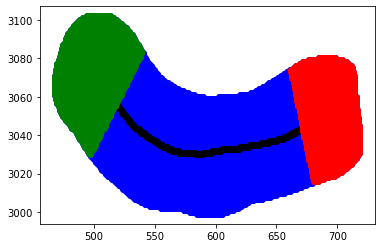

dipole gene= 0.8598768607625722
elongation= 195
aspect ratio= 0.41434262948207173
centroid= [ 589 3045]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8906535001779451
elongation= 260
aspect ratio= 0.37209302325581395
centroid= [ 607 1819]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


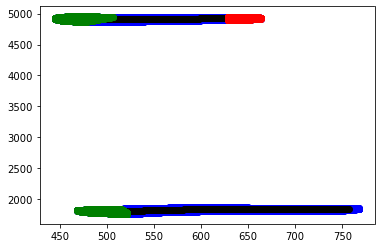

dipole gene= 0.9547321232476302
elongation= 167
aspect ratio= 0.4409090909090909
centroid= [ 544 4914]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


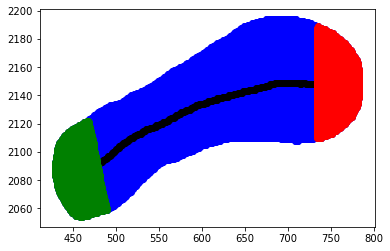

dipole gene= 0.7473364768789386
elongation= 292
aspect ratio= 0.3971830985915493
centroid= [ 612 2130]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


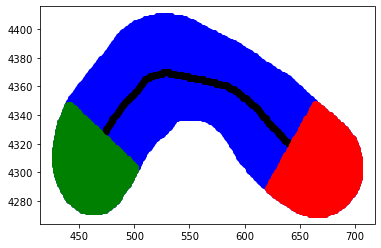

dipole gene= 0.8476610462069342
elongation= 219
aspect ratio= 0.5018050541516246
centroid= [ 558 4337]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


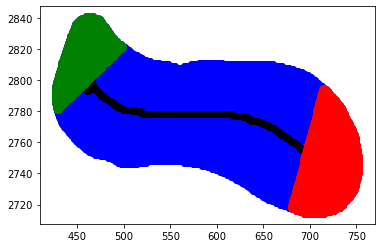

dipole gene= 0.722960575905722
elongation= 277
aspect ratio= 0.3902439024390244
centroid= [ 592 2774]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.905683837394816
elongation= 240
aspect ratio= 0.4014336917562724
centroid= [ 553 4025]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


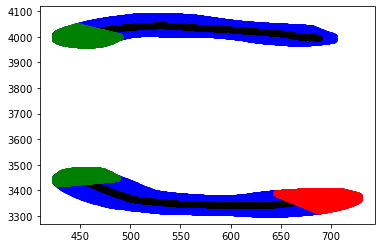

dipole gene= 0.8510376340116509
elongation= 276
aspect ratio= 0.569078947368421
centroid= [ 565 3373]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9074305705094572
elongation= 280
aspect ratio= 0.34076433121019106
centroid= [ 540 4603]
0.0007396000000881031


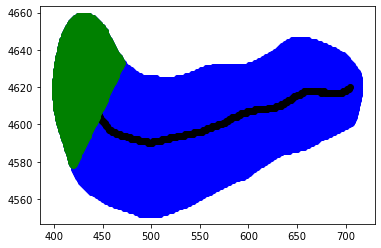

In [70]:
# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
start = timeit.timeit()
dipole_list=np.empty([1,0])
elongation_list=np.empty([1,0])
aspect_ratio_list=np.empty([1,0])
centroid_list=[[1,1], [1,1]]
true_org=np.empty([1,0])

for ii in range(np.shape(contours)[0]):
    
    M = cv2.moments(contours[ii])
    if M["m00"] == 0:
        true_org=np.append(true_org,0)
    else:
        true_org=np.append(true_org,1)


for ii in range(np.shape(contours)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))

        obj = np.argwhere(filled_array == 255)

        

        bin_arr = np.where(filled_array > 0, 1, 0)
    
        image = bin_arr

    # perform skeletonization
    
        skeleton1 = skeletonize(image)


        binSkel = skeleton1*1
        skelObj = np.argwhere(binSkel == 1)

        fil = FilFinder2D(binSkel, distance=250 * u.pc, mask=skeleton1)
        fil.preprocess_image(flatten_percent=85)
        fil.create_mask(border_masking=True, verbose=False,
        use_existing_mask=True)
        fil.medskel(verbose=False)
        fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')
        skeleton_length=fil.lengths()
        plt.plot(obj[:,0],obj[:,1], 'bo')
        plt.plot(skelObj[:,0],skelObj[:,1], 'ko')


        x,y,w,h = cv2.boundingRect(contours[ii])
        aspect_ratio = float(w)/h
        M = cv2.moments(contours[ii])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid=np.array([cY,cX])
        hey_1 = np.argwhere(fil.skeleton_longpath==1)
        if hey_1.size==0:
            hey_1=skelObj
        im_zer = np.zeros( (img.shape[0],img.shape[1]) )
        skele_im=im_zer
        skele_im[hey_1[:,0],hey_1[:,1]]=255
        n=0
        ma=np.array([1,1,1])
        ok2=0
        while ok2==0:
            
            in_x=hey_1[n,0]
            in_y=hey_1[n,1]
            ma=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
            n=n+1
            if np.sum(ma)<255*3:
                ok2=1
        skeleton=np.array([[0,1],[in_x, in_y]])
        ok=0
        x_prev=1
        y_prev=1
        neighbors=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
        center_y=in_y
        center_x=in_x
        n=0
        while ok==0:
        
        
            neighbors[x_prev,y_prev]=0
            neighbors[1,1]=0
            res=np.where(neighbors==255)
            if res[0].size==0 :
         
                break
        
            y_next=res[1]
            x_next=res[0]
            skeleton=np.append(skeleton, [[x_next[0]-1+center_x, y_next[0]-1+center_y]], axis=0)
            y_prev=2-y_next[0]
            x_prev=2-x_next[0]
        
            center_y=center_y+y_next[0]-1
            center_x=center_x+x_next[0]-1
        
            neighbors=skele_im[-1+center_x:2+center_x,-1+center_y:2+center_y]
        

        skeleton=np.delete(skeleton, 0,0)
        hey=skeleton
        epsilon=20
        if np.shape(hey)[0]<6:
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
        elongation=np.shape(hey)[0]
        dipole=get_gene_dipole(hey,contours[ii],epsilon,img_gene1,img_gene2)
        dipole_list=np.append(dipole_list,dipole)
        elongation_list=np.append(elongation_list,elongation)
        aspect_ratio_list=np.append(aspect_ratio_list,aspect_ratio)
        centroid_list=np.append(centroid_list,[centroid],axis=0)
        print('dipole gene=',dipole)
        print('elongation=',elongation)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
centroid_list=np.delete(centroid_list, [0,1],0)
end = timeit.timeit()
print(end - start)

In [80]:
# save data, there is probably a better way to do this, but I am not sure
name="dipole_list.txt"
df = pd.DataFrame(data=dipole_list)
df.to_csv(name, index=False)

name="elongation.txt"
df = pd.DataFrame(data=elongation_list)
df.to_csv(name, index=False)

name="aspect_ratio.txt"
df = pd.DataFrame(data=aspect_ratio_list)
df.to_csv(name, index=False)

name="centroid.txt"
df = pd.DataFrame(data=centroid_list)
df.to_csv(name, index=False)